In [1]:
import tensorflow as tf
print("TensorFlow version: %s" % tf.__version__)
for device in tf.config.list_physical_devices():
    print(device)

TensorFlow version: 2.3.1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')


In [2]:
#!pip install -U keras-tuner

In [3]:
#!pip install -U tensorflow-addons

In [4]:
import tensorflow_addons as tfa

In [5]:
import numpy as np
import pandas as pd

from tensorflow import keras
print("Keras vs: %s" % keras.__version__)

K = keras.backend
layers = keras.layers
models = keras.models
optimizers = keras.optimizers
losses = keras.losses
pad_sequences = keras.preprocessing.sequence.pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, RepeatVector, dot, multiply, Permute, Lambda
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Keras vs: 2.4.0


In [6]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [7]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(train_data, 
                                                                  train_labels, 
                                                                  test_size=0.30, 
                                                                  shuffle=True,
                                                                  random_state=0)

In [8]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [9]:
pad_length = 256

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=pad_length)

val_data = keras.preprocessing.sequence.pad_sequences(val_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=pad_length)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=pad_length)

In [10]:
def attention(layer):
    # --- Attention is all you need --- #
    _,_,units = layer.shape.as_list()
    attention = Dense(1, activation='tanh')(layer)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)
    representation = multiply([layer, attention])
    representation = Lambda(lambda x: K.sum(x, axis=-2), 
                            output_shape=(units,))(representation)
    # ---------------------------------- #
    return representation


def create_model(vocab_size=10000, pad_length=256, multigpu=False):

    embedding_size=256
    inputs = layers.Input(name='inputs',shape=[pad_length])
    layer  = layers.Embedding(vocab_size, embedding_size, input_length=pad_length)(inputs)
    layer  = layers.SpatialDropout1D(0.3)(layer)
    
    conv = layers.Conv1D(filters=128, kernel_size=4, 
                         padding='valid', kernel_initializer='he_uniform')(layer)
    avg_pool_conv = layers.GlobalAveragePooling1D()(conv)
    max_pool_conv = layers.GlobalMaxPooling1D()(conv)
    
    layer  = layers.Bidirectional(layers.GRU(128, return_sequences=True))(layer)

    sent_representation_1 = attention(layer)

    layer  = layers.Bidirectional(layers.GRU(64, return_sequences=True))(layer)

    sent_representation_2 = attention(layer)

    layer = layers.concatenate([sent_representation_1, sent_representation_2,
                                avg_pool_conv, max_pool_conv])

    layer = layers.Dropout(0.3)(layer)
    layer = layers.Dense(32, name='FC1')(layer)
    layer  = layers.LeakyReLU()(layer)
    layer = layers.Dropout(0.3)(layer)
    layer  = layers.Dense(1, name='out_layer')(layer)
    outputs  = layers.Activation('sigmoid')(layer)

    model  = models.Model(inputs=inputs, outputs=outputs)
    
    if multigpu:
        model = multi_gpu_model(model, gpus=2)

    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [11]:
model = create_model()
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 256, 256)     2560000     inputs[0][0]                     
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 256, 256)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 256, 256)     296448      spatial_dropout1d_4[0][0]        
_______________________________________________________________________________________

In [12]:
history = model.fit(train_data,
                    train_labels,
                    epochs=30,
                    batch_size=64,
                    validation_data=(val_data, val_labels),
                    shuffle=True,
                    callbacks=[EarlyStopping('val_acc', patience=3, restore_best_weights=True)],
                    verbose=2)

Epoch 1/30
274/274 - 19s - loss: 0.1202 - acc: 0.9557 - val_loss: 0.3398 - val_acc: 0.8809
Epoch 2/30
274/274 - 19s - loss: 0.0721 - acc: 0.9755 - val_loss: 0.4097 - val_acc: 0.8793
Epoch 3/30
274/274 - 20s - loss: 0.0492 - acc: 0.9835 - val_loss: 0.4853 - val_acc: 0.8809
Epoch 4/30
274/274 - 19s - loss: 0.0301 - acc: 0.9899 - val_loss: 0.5758 - val_acc: 0.8815
Epoch 5/30
274/274 - 19s - loss: 0.0187 - acc: 0.9934 - val_loss: 0.7631 - val_acc: 0.8652
Epoch 6/30
274/274 - 19s - loss: 0.0219 - acc: 0.9926 - val_loss: 0.6328 - val_acc: 0.8760
Epoch 7/30
274/274 - 19s - loss: 0.0190 - acc: 0.9929 - val_loss: 0.9076 - val_acc: 0.8625


In [13]:
model.save("baseline_model.h5")

In [14]:
results = model.evaluate(test_data, test_labels, verbose=0)
print("Loss %0.3f | Accuracy %0.3f" % tuple(results))

Loss 0.610 | Accuracy 0.868


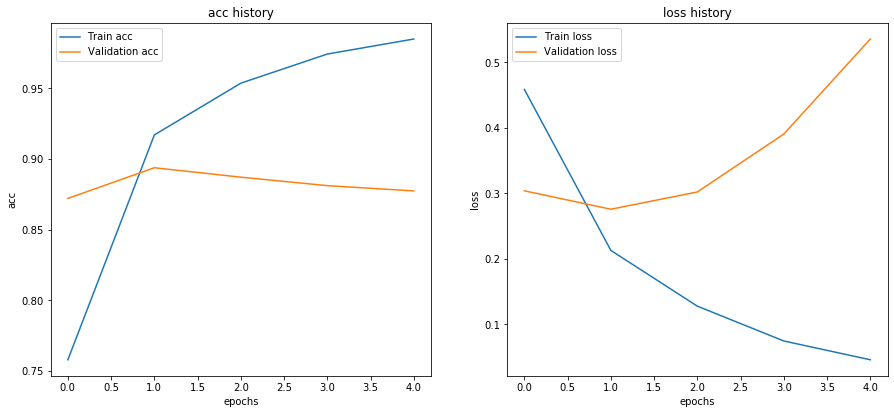

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)
    
plot_keras_history(history, measures=['acc', 'loss'])

In [16]:
def get_optimizer(option=0, learning_rate=0.001):
    if option==0:
        return tf.keras.optimizers.Adam(learning_rate)
    elif option==1:
        return tf.keras.optimizers.SGD(learning_rate, momentum=0.9, nesterov=True)
    elif option==2:
        return tfa.optimizers.RectifiedAdam(learning_rate)
    elif option==3:
        return tfa.optimizers.Lookahead(tf.optimizers.Adam(learning_rate), sync_period=3)
    elif option==4:
        return tfa.optimizers.SWA(tf.optimizers.Adam(learning_rate))
    elif option==5:
        return tfa.optimizers.SWA(tf.keras.optimizers.SGD(learning_rate, momentum=0.9, nesterov=True))
    else:
        return tf.keras.optimizers.Adam(learning_rate)
    
def create_tunable_model(hp, vocab_size=10000, pad_length=256, multigpu=False):

    # Instantiate model params
    embedding_size = hp.Int('embedding_size', min_value=8, max_value=512, step=8)
    spatial_dropout = hp.Float('spatial_dropout', min_value=0, max_value=0.5, step=0.05)

    conv_layers = hp.Int('conv_layers', min_value=1, max_value=5, step=1)
    rnn_layers = hp.Int('rnn_layers', min_value=1, max_value=5, step=1)
    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)

    conv_filters = hp.Int('conv_filters', min_value=32, max_value=512, step=32)
    conv_kernel = hp.Int('conv_kernel', min_value=1, max_value=8, step=1)

    concat_dropout = hp.Float('concat_dropout', min_value=0, max_value=0.5, step=0.05)
    dense_dropout = hp.Float('dense_dropout', min_value=0, max_value=0.5, step=0.05)

    inputs = layers.Input(name='inputs',shape=[pad_length])
    layer  = layers.Embedding(vocab_size, embedding_size, input_length=pad_length)(inputs)
    layer  = layers.SpatialDropout1D(spatial_dropout)(layer)

    for l in range(conv_layers):
        if l==0:
            conv = layers.Conv1D(filters=conv_filters, kernel_size=conv_kernel, 
                                 padding='valid', kernel_initializer='he_uniform')(layer)
        else:
            conv = layers.Conv1D(filters=conv_filters, kernel_size=conv_kernel, 
                                 padding='valid', kernel_initializer='he_uniform')(conv) 

    avg_pool_conv = layers.GlobalAveragePooling1D()(conv)
    max_pool_conv = layers.GlobalMaxPooling1D()(conv)

    representations = list()
    for l in range(rnn_layers):
        
        use_bidirectional = hp.Choice(f'use_bidirectional_{l}', values=[0, 1])
        use_lstm = hp.Choice(f'use_lstm_{l}', values=[0, 1])
        units = hp.Int(f'units_{l}', min_value=8, max_value=512, step=8)

        if use_lstm == 1:
            rnl = layers.LSTM
        else:
            rnl = layers.GRU

        if use_bidirectional==1:
            layer = layers.Bidirectional(rnl(units, return_sequences=True))(layer)
        else:
            layer = rnl(units, return_sequences=True)(layer)

        representations.append(attention(layer))

    layer = layers.concatenate(representations + [avg_pool_conv, max_pool_conv])
    layer = layers.Dropout(concat_dropout)(layer)

    for l in range(dense_layers):
        dense_units = hp.Int(f'dense_units_{l}', min_value=8, max_value=512, step=8)
        layer = layers.Dense(dense_units)(layer)
        layer  = layers.LeakyReLU()(layer)
        layer = layers.Dropout(dense_dropout)(layer)

    layer  = layers.Dense(1, name='out_layer')(layer)
    outputs  = layers.Activation('sigmoid')(layer)

    model  = models.Model(inputs=inputs, outputs=outputs)
    
    if multigpu:
        model = multi_gpu_model(model, gpus=2)

    hp_learning_rate = hp.Choice('learning_rate', values=[0.002, 0.001, 0.0005])
    optimizer_type = hp.Choice('optimizer', values=list(range(6)))
    optimizer = get_optimizer(option=optimizer_type, learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [17]:
import kerastuner as kt

In [18]:
tuner = kt.BayesianOptimization(hypermodel=create_tunable_model,
                                objective='val_acc',
                                max_trials=100,
                                num_initial_points=3,
                                directory='storage',
                                project_name='imdb',
                                seed=42)

tuner.search(train_data, train_labels, 
             epochs=30,
             batch_size=64, 
             validation_data=(val_data, val_labels),
             shuffle=True,
             verbose=2,
             callbacks = [EarlyStopping('val_acc', patience=3, restore_best_weights=True)]
             )

Epoch 1/30
274/274 - 21s - loss: 0.4769 - acc: 0.7628 - val_loss: 0.3211 - val_acc: 0.8639
Epoch 2/30
274/274 - 20s - loss: 0.2676 - acc: 0.8999 - val_loss: 0.3730 - val_acc: 0.8709
Epoch 3/30
274/274 - 20s - loss: 0.1911 - acc: 0.9307 - val_loss: 0.4138 - val_acc: 0.8633
Epoch 4/30
274/274 - 20s - loss: 0.1206 - acc: 0.9586 - val_loss: 0.6186 - val_acc: 0.8633
Epoch 5/30
274/274 - 20s - loss: 0.0806 - acc: 0.9739 - val_loss: 0.8233 - val_acc: 0.8695


Epoch 1/30
274/274 - 21s - loss: 0.5853 - acc: 0.6471 - val_loss: 0.3585 - val_acc: 0.8429
Epoch 2/30
274/274 - 21s - loss: 0.3437 - acc: 0.8525 - val_loss: 0.2959 - val_acc: 0.8737
Epoch 3/30
274/274 - 21s - loss: 0.2710 - acc: 0.8887 - val_loss: 0.2806 - val_acc: 0.8839
Epoch 4/30
274/274 - 21s - loss: 0.2214 - acc: 0.9131 - val_loss: 0.2672 - val_acc: 0.8875
Epoch 5/30
274/274 - 21s - loss: 0.2014 - acc: 0.9185 - val_loss: 0.2706 - val_acc: 0.8929
Epoch 6/30
274/274 - 21s - loss: 0.1764 - acc: 0.9307 - val_loss: 0.3305 - val_acc: 0.8721
Epoch 7/30
274/274 - 21s - loss: 0.1583 - acc: 0.9398 - val_loss: 0.3138 - val_acc: 0.8831
Epoch 8/30
274/274 - 21s - loss: 0.1240 - acc: 0.9521 - val_loss: 0.3886 - val_acc: 0.8823


Epoch 1/30
274/274 - 28s - loss: 0.4133 - acc: 0.7955 - val_loss: 0.2806 - val_acc: 0.8847
Epoch 2/30
274/274 - 27s - loss: 0.1984 - acc: 0.9247 - val_loss: 0.2537 - val_acc: 0.8943
Epoch 3/30
274/274 - 27s - loss: 0.1131 - acc: 0.9595 - val_loss: 0.3814 - val_acc: 0.8724
Epoch 4/30
274/274 - 27s - loss: 0.0703 - acc: 0.9751 - val_loss: 0.4322 - val_acc: 0.8679
Epoch 5/30
274/274 - 27s - loss: 0.0454 - acc: 0.9842 - val_loss: 0.6076 - val_acc: 0.8665


Epoch 1/30
274/274 - 27s - loss: 0.6937 - acc: 0.4998 - val_loss: 0.6928 - val_acc: 0.5085
Epoch 2/30
274/274 - 26s - loss: 0.6936 - acc: 0.5037 - val_loss: 0.6926 - val_acc: 0.5067
Epoch 3/30
274/274 - 26s - loss: 0.6932 - acc: 0.5034 - val_loss: 0.6926 - val_acc: 0.5060
Epoch 4/30
274/274 - 26s - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6927 - val_acc: 0.5041


Epoch 1/30
274/274 - 38s - loss: 0.5404 - acc: 0.7241 - val_loss: 0.3654 - val_acc: 0.8420
Epoch 2/30
274/274 - 37s - loss: 0.2725 - acc: 0.8950 - val_loss: 0.3072 - val_acc: 0.8744
Epoch 3/30
274/274 - 37s - loss: 0.2128 - acc: 0.9213 - val_loss: 0.5956 - val_acc: 0.7581
Epoch 4/30
274/274 - 37s - loss: 126.6490 - acc: 0.7113 - val_loss: 0.5787 - val_acc: 0.8165
Epoch 5/30
274/274 - 37s - loss: 0.5671 - acc: 0.8372 - val_loss: 0.4361 - val_acc: 0.8444


Epoch 1/30
274/274 - 23s - loss: 0.5057 - acc: 0.7447 - val_loss: 0.3362 - val_acc: 0.8575
Epoch 2/30
274/274 - 23s - loss: 0.2871 - acc: 0.8839 - val_loss: 0.3157 - val_acc: 0.8653
Epoch 3/30
274/274 - 23s - loss: 0.2086 - acc: 0.9194 - val_loss: 0.3840 - val_acc: 0.8739
Epoch 4/30
274/274 - 22s - loss: 0.1395 - acc: 0.9466 - val_loss: 0.4077 - val_acc: 0.8683
Epoch 5/30
274/274 - 22s - loss: 0.1043 - acc: 0.9600 - val_loss: 0.4849 - val_acc: 0.8660
Epoch 6/30
274/274 - 22s - loss: 38.4746 - acc: 0.8198 - val_loss: 1.7117 - val_acc: 0.7927


Epoch 1/30
274/274 - 18s - loss: 0.6944 - acc: 0.5054 - val_loss: 0.6925 - val_acc: 0.4968
Epoch 2/30
274/274 - 17s - loss: 0.6933 - acc: 0.5122 - val_loss: 0.6913 - val_acc: 0.5061
Epoch 3/30
274/274 - 17s - loss: 0.6918 - acc: 0.5173 - val_loss: 0.6903 - val_acc: 0.5064
Epoch 4/30
274/274 - 17s - loss: 0.6912 - acc: 0.5253 - val_loss: 0.6900 - val_acc: 0.4977
Epoch 5/30
274/274 - 17s - loss: 0.6895 - acc: 0.5327 - val_loss: 0.6856 - val_acc: 0.6139
Epoch 6/30
274/274 - 17s - loss: 0.6865 - acc: 0.5521 - val_loss: 0.6823 - val_acc: 0.5417
Epoch 7/30
274/274 - 17s - loss: 0.6796 - acc: 0.5823 - val_loss: 0.6728 - val_acc: 0.6049
Epoch 8/30
274/274 - 17s - loss: 0.6681 - acc: 0.6085 - val_loss: 0.6583 - val_acc: 0.6037


Epoch 1/30
274/274 - 25s - loss: 0.7064 - acc: 0.4969 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 2/30
274/274 - 24s - loss: 0.6966 - acc: 0.5049 - val_loss: 0.6924 - val_acc: 0.5128
Epoch 3/30
274/274 - 25s - loss: 0.6962 - acc: 0.5011 - val_loss: 0.6925 - val_acc: 0.5256
Epoch 4/30
274/274 - 24s - loss: 0.6950 - acc: 0.5051 - val_loss: 0.6922 - val_acc: 0.5060
Epoch 5/30
274/274 - 24s - loss: 0.6950 - acc: 0.5085 - val_loss: 0.6919 - val_acc: 0.5125
Epoch 6/30
274/274 - 25s - loss: 0.6941 - acc: 0.5080 - val_loss: 0.6912 - val_acc: 0.5813
Epoch 7/30
274/274 - 24s - loss: 0.6929 - acc: 0.5161 - val_loss: 0.6896 - val_acc: 0.5069
Epoch 8/30
274/274 - 25s - loss: 0.6904 - acc: 0.5322 - val_loss: 0.6827 - val_acc: 0.6201
Epoch 9/30
274/274 - 25s - loss: 0.6761 - acc: 0.5706 - val_loss: 0.6459 - val_acc: 0.6519
Epoch 10/30
274/274 - 24s - loss: 0.6224 - acc: 0.6566 - val_loss: 0.6401 - val_acc: 0.6203
Epoch 11/30
274/274 - 25s - loss: 0.5523 - acc: 0.7267 - val_loss: 0.5261 - val_acc: 0.72

Epoch 1/30
274/274 - 33s - loss: 0.4722 - acc: 0.7440 - val_loss: 0.2858 - val_acc: 0.8785
Epoch 2/30
274/274 - 33s - loss: 0.2285 - acc: 0.9093 - val_loss: 0.2752 - val_acc: 0.8889
Epoch 3/30
274/274 - 32s - loss: 0.1396 - acc: 0.9470 - val_loss: 0.3212 - val_acc: 0.8844
Epoch 4/30
274/274 - 32s - loss: 0.0856 - acc: 0.9699 - val_loss: 0.3711 - val_acc: 0.8767
Epoch 5/30
274/274 - 32s - loss: 0.0547 - acc: 0.9805 - val_loss: 0.4969 - val_acc: 0.8748


Epoch 1/30
274/274 - 13s - loss: 0.4593 - acc: 0.7643 - val_loss: 0.2893 - val_acc: 0.8793
Epoch 2/30
274/274 - 12s - loss: 0.2268 - acc: 0.9100 - val_loss: 0.3279 - val_acc: 0.8687
Epoch 3/30
274/274 - 12s - loss: 0.1216 - acc: 0.9542 - val_loss: 0.3048 - val_acc: 0.8873
Epoch 4/30
274/274 - 12s - loss: 0.0604 - acc: 0.9782 - val_loss: 0.3793 - val_acc: 0.8804
Epoch 5/30
274/274 - 12s - loss: 0.0377 - acc: 0.9869 - val_loss: 0.6708 - val_acc: 0.8795
Epoch 6/30
274/274 - 12s - loss: 0.0288 - acc: 0.9895 - val_loss: 0.8832 - val_acc: 0.8208


Epoch 1/30
274/274 - 30s - loss: 0.6947 - acc: 0.5018 - val_loss: 0.6930 - val_acc: 0.5053
Epoch 2/30
274/274 - 28s - loss: 0.6941 - acc: 0.5052 - val_loss: 0.6928 - val_acc: 0.4951
Epoch 3/30
274/274 - 28s - loss: 0.6945 - acc: 0.5037 - val_loss: 0.6921 - val_acc: 0.5087
Epoch 4/30
274/274 - 29s - loss: 0.6939 - acc: 0.5113 - val_loss: 0.6913 - val_acc: 0.5644
Epoch 5/30
274/274 - 29s - loss: 0.6935 - acc: 0.5082 - val_loss: 0.6907 - val_acc: 0.5940
Epoch 6/30
274/274 - 29s - loss: 0.6928 - acc: 0.5158 - val_loss: 0.6901 - val_acc: 0.6159
Epoch 7/30
274/274 - 29s - loss: 0.6917 - acc: 0.5215 - val_loss: 0.6893 - val_acc: 0.6309
Epoch 8/30
274/274 - 29s - loss: 0.6909 - acc: 0.5235 - val_loss: 0.6885 - val_acc: 0.6369
Epoch 9/30
274/274 - 29s - loss: 0.6904 - acc: 0.5319 - val_loss: 0.6875 - val_acc: 0.6388
Epoch 10/30
274/274 - 29s - loss: 0.6898 - acc: 0.5341 - val_loss: 0.6863 - val_acc: 0.6512
Epoch 11/30
274/274 - 28s - loss: 0.6883 - acc: 0.5446 - val_loss: 0.6851 - val_acc: 0.63

Epoch 1/30
274/274 - 68s - loss: 0.6950 - acc: 0.5017 - val_loss: 0.6932 - val_acc: 0.4935
Epoch 2/30
274/274 - 67s - loss: 0.6949 - acc: 0.4978 - val_loss: 0.6930 - val_acc: 0.5141
Epoch 3/30
274/274 - 67s - loss: 0.6939 - acc: 0.5035 - val_loss: 0.6930 - val_acc: 0.5073
Epoch 4/30
274/274 - 67s - loss: 0.6940 - acc: 0.5022 - val_loss: 0.6930 - val_acc: 0.4975
Epoch 5/30
274/274 - 67s - loss: 0.6943 - acc: 0.4935 - val_loss: 0.6929 - val_acc: 0.5241
Epoch 6/30
274/274 - 67s - loss: 0.6944 - acc: 0.4972 - val_loss: 0.6929 - val_acc: 0.5267
Epoch 7/30
274/274 - 67s - loss: 0.6932 - acc: 0.5071 - val_loss: 0.6928 - val_acc: 0.5287
Epoch 8/30
274/274 - 67s - loss: 0.6937 - acc: 0.5047 - val_loss: 0.6927 - val_acc: 0.5357
Epoch 9/30
274/274 - 66s - loss: 0.6937 - acc: 0.5051 - val_loss: 0.6928 - val_acc: 0.5199
Epoch 10/30
274/274 - 67s - loss: 0.6933 - acc: 0.5063 - val_loss: 0.6927 - val_acc: 0.5373
Epoch 11/30
274/274 - 67s - loss: 0.6931 - acc: 0.5034 - val_loss: 0.6926 - val_acc: 0.54

Epoch 1/30
274/274 - 46s - loss: 0.5281 - acc: 0.7307 - val_loss: 0.3762 - val_acc: 0.8369
Epoch 2/30
274/274 - 45s - loss: 0.3784 - acc: 0.8350 - val_loss: 0.3657 - val_acc: 0.8421
Epoch 3/30
274/274 - 45s - loss: 0.2659 - acc: 0.8909 - val_loss: 0.3269 - val_acc: 0.8727
Epoch 4/30
274/274 - 45s - loss: 0.1961 - acc: 0.9242 - val_loss: 0.3466 - val_acc: 0.8783
Epoch 5/30
274/274 - 44s - loss: 0.1450 - acc: 0.9451 - val_loss: 0.4604 - val_acc: 0.8713
Epoch 6/30
274/274 - 45s - loss: 0.1034 - acc: 0.9615 - val_loss: 0.4346 - val_acc: 0.8691
Epoch 7/30
274/274 - 45s - loss: 0.0725 - acc: 0.9709 - val_loss: 0.5321 - val_acc: 0.8753


Epoch 1/30
274/274 - 63s - loss: 0.4657 - acc: 0.7720 - val_loss: 0.4722 - val_acc: 0.7688
Epoch 2/30
274/274 - 63s - loss: 0.2537 - acc: 0.8990 - val_loss: 0.2954 - val_acc: 0.8743
Epoch 3/30
274/274 - 64s - loss: 0.1592 - acc: 0.9398 - val_loss: 0.3082 - val_acc: 0.8811
Epoch 4/30
274/274 - 63s - loss: 0.1097 - acc: 0.9591 - val_loss: 0.4355 - val_acc: 0.8695
Epoch 5/30
274/274 - 63s - loss: 0.0765 - acc: 0.9711 - val_loss: 0.5342 - val_acc: 0.8652
Epoch 6/30
274/274 - 62s - loss: 0.0553 - acc: 0.9795 - val_loss: 0.4825 - val_acc: 0.8708


Epoch 1/30
274/274 - 28s - loss: 0.6713 - acc: 0.5659 - val_loss: 0.4276 - val_acc: 0.8167
Epoch 2/30
274/274 - 27s - loss: 0.4327 - acc: 0.8110 - val_loss: 0.3263 - val_acc: 0.8556
Epoch 3/30
274/274 - 26s - loss: 0.3265 - acc: 0.8671 - val_loss: 0.3380 - val_acc: 0.8517
Epoch 4/30
274/274 - 27s - loss: 0.2685 - acc: 0.8947 - val_loss: 0.3196 - val_acc: 0.8671
Epoch 5/30
274/274 - 26s - loss: 0.2260 - acc: 0.9117 - val_loss: 0.3258 - val_acc: 0.8620
Epoch 6/30
274/274 - 26s - loss: 0.2097 - acc: 0.9218 - val_loss: 0.4855 - val_acc: 0.8589
Epoch 7/30
274/274 - 27s - loss: 0.2146 - acc: 0.9190 - val_loss: 0.3287 - val_acc: 0.8784
Epoch 8/30
274/274 - 26s - loss: 0.1884 - acc: 0.9325 - val_loss: 0.4087 - val_acc: 0.8708
Epoch 9/30
274/274 - 26s - loss: 0.1913 - acc: 0.9293 - val_loss: 0.4652 - val_acc: 0.8676
Epoch 10/30
274/274 - 27s - loss: 0.1791 - acc: 0.9380 - val_loss: 0.6100 - val_acc: 0.8679


Epoch 1/30
274/274 - 50s - loss: 0.6945 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.5056
Epoch 2/30
274/274 - 49s - loss: 0.6942 - acc: 0.4964 - val_loss: 0.6931 - val_acc: 0.5056
Epoch 3/30
274/274 - 49s - loss: 0.6942 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5119
Epoch 4/30
274/274 - 49s - loss: 0.6940 - acc: 0.4996 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 5/30
274/274 - 50s - loss: 0.6943 - acc: 0.4958 - val_loss: 0.6930 - val_acc: 0.5208
Epoch 6/30
274/274 - 49s - loss: 0.6935 - acc: 0.5067 - val_loss: 0.6931 - val_acc: 0.4967
Epoch 7/30
274/274 - 49s - loss: 0.6936 - acc: 0.5050 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 8/30
274/274 - 49s - loss: 0.6933 - acc: 0.5031 - val_loss: 0.6930 - val_acc: 0.5229
Epoch 9/30
274/274 - 49s - loss: 0.6939 - acc: 0.4946 - val_loss: 0.6929 - val_acc: 0.5288
Epoch 10/30
274/274 - 49s - loss: 0.6935 - acc: 0.5047 - val_loss: 0.6929 - val_acc: 0.5059
Epoch 11/30
274/274 - 49s - loss: 0.6934 - acc: 0.5002 - val_loss: 0.6929 - val_acc: 0.53

Epoch 1/30
274/274 - 15s - loss: 0.4466 - acc: 0.7793 - val_loss: 0.3172 - val_acc: 0.8724
Epoch 2/30
274/274 - 14s - loss: 0.2148 - acc: 0.9163 - val_loss: 0.2627 - val_acc: 0.8951
Epoch 3/30
274/274 - 14s - loss: 0.1249 - acc: 0.9549 - val_loss: 0.2945 - val_acc: 0.8840
Epoch 4/30
274/274 - 14s - loss: 0.0774 - acc: 0.9704 - val_loss: 0.4624 - val_acc: 0.8837
Epoch 5/30
274/274 - 14s - loss: 0.0578 - acc: 0.9790 - val_loss: 0.5161 - val_acc: 0.8765


Epoch 1/30
274/274 - 34s - loss: 0.4688 - acc: 0.7590 - val_loss: 0.3269 - val_acc: 0.8552
Epoch 2/30
274/274 - 33s - loss: 0.2577 - acc: 0.8954 - val_loss: 0.3485 - val_acc: 0.8620
Epoch 3/30
274/274 - 33s - loss: 0.1759 - acc: 0.9318 - val_loss: 0.3085 - val_acc: 0.8729
Epoch 4/30
274/274 - 33s - loss: 0.1118 - acc: 0.9598 - val_loss: 0.4594 - val_acc: 0.8640
Epoch 5/30
274/274 - 33s - loss: 0.0818 - acc: 0.9689 - val_loss: 0.5138 - val_acc: 0.8665
Epoch 6/30
274/274 - 33s - loss: 0.0878 - acc: 0.9681 - val_loss: 0.6116 - val_acc: 0.8512


Epoch 1/30
274/274 - 34s - loss: 0.5077 - acc: 0.7338 - val_loss: 0.3170 - val_acc: 0.8653
Epoch 2/30
274/274 - 33s - loss: 0.2886 - acc: 0.8819 - val_loss: 0.2828 - val_acc: 0.8831
Epoch 3/30
274/274 - 32s - loss: 0.1961 - acc: 0.9217 - val_loss: 0.3030 - val_acc: 0.8821
Epoch 4/30
274/274 - 33s - loss: 0.1458 - acc: 0.9439 - val_loss: 0.3246 - val_acc: 0.8855
Epoch 5/30
274/274 - 32s - loss: 0.1031 - acc: 0.9629 - val_loss: 0.3402 - val_acc: 0.8792
Epoch 6/30
274/274 - 32s - loss: 0.0732 - acc: 0.9740 - val_loss: 0.4310 - val_acc: 0.8747
Epoch 7/30
274/274 - 32s - loss: 0.0642 - acc: 0.9755 - val_loss: 0.5942 - val_acc: 0.8723


Epoch 1/30
274/274 - 36s - loss: 0.5978 - acc: 0.6317 - val_loss: 0.3295 - val_acc: 0.8567
Epoch 2/30
274/274 - 35s - loss: 0.2875 - acc: 0.8843 - val_loss: 0.2940 - val_acc: 0.8788
Epoch 3/30
274/274 - 35s - loss: 0.1920 - acc: 0.9281 - val_loss: 0.2740 - val_acc: 0.8888
Epoch 4/30
274/274 - 34s - loss: 0.1349 - acc: 0.9506 - val_loss: 0.3381 - val_acc: 0.8845
Epoch 5/30
274/274 - 34s - loss: 0.0896 - acc: 0.9679 - val_loss: 0.4476 - val_acc: 0.8785
Epoch 6/30
274/274 - 34s - loss: 0.0617 - acc: 0.9778 - val_loss: 0.5014 - val_acc: 0.8747


Epoch 1/30
274/274 - 41s - loss: 0.4114 - acc: 0.7975 - val_loss: 0.2816 - val_acc: 0.8867
Epoch 2/30
274/274 - 40s - loss: 0.2048 - acc: 0.9219 - val_loss: 0.3162 - val_acc: 0.8799
Epoch 3/30
274/274 - 40s - loss: 0.1012 - acc: 0.9649 - val_loss: 0.3639 - val_acc: 0.8751
Epoch 4/30
274/274 - 40s - loss: 0.0672 - acc: 0.9764 - val_loss: 0.4510 - val_acc: 0.8840


Epoch 1/30
274/274 - 22s - loss: 0.6071 - acc: 0.6323 - val_loss: 0.4198 - val_acc: 0.7915
Epoch 2/30
274/274 - 22s - loss: 0.3691 - acc: 0.8387 - val_loss: 0.2936 - val_acc: 0.8761
Epoch 3/30
274/274 - 22s - loss: 0.2760 - acc: 0.8891 - val_loss: 0.2743 - val_acc: 0.8821
Epoch 4/30
274/274 - 22s - loss: 0.2178 - acc: 0.9143 - val_loss: 0.2803 - val_acc: 0.8841
Epoch 5/30
274/274 - 22s - loss: 0.1780 - acc: 0.9309 - val_loss: 0.2659 - val_acc: 0.8923
Epoch 6/30
274/274 - 21s - loss: 0.1384 - acc: 0.9474 - val_loss: 0.2936 - val_acc: 0.8899
Epoch 7/30
274/274 - 21s - loss: 0.1115 - acc: 0.9589 - val_loss: 0.3572 - val_acc: 0.8871
Epoch 8/30
274/274 - 21s - loss: 0.0843 - acc: 0.9694 - val_loss: 0.4032 - val_acc: 0.8801


Epoch 1/30
274/274 - 28s - loss: 0.5221 - acc: 0.7106 - val_loss: 0.3617 - val_acc: 0.8449
Epoch 2/30
274/274 - 27s - loss: 0.2559 - acc: 0.8992 - val_loss: 0.3000 - val_acc: 0.8749
Epoch 3/30
274/274 - 27s - loss: 0.1570 - acc: 0.9410 - val_loss: 0.3230 - val_acc: 0.8743
Epoch 4/30
274/274 - 27s - loss: 0.1003 - acc: 0.9636 - val_loss: 0.4584 - val_acc: 0.8505
Epoch 5/30
274/274 - 27s - loss: 0.0689 - acc: 0.9754 - val_loss: 0.4170 - val_acc: 0.8679


Epoch 1/30
274/274 - 33s - loss: 0.4399 - acc: 0.7817 - val_loss: 0.3088 - val_acc: 0.8707
Epoch 2/30
274/274 - 32s - loss: 0.2351 - acc: 0.9071 - val_loss: 0.3561 - val_acc: 0.8653
Epoch 3/30
274/274 - 32s - loss: 0.1366 - acc: 0.9469 - val_loss: 0.3739 - val_acc: 0.8685
Epoch 4/30
274/274 - 32s - loss: 0.0878 - acc: 0.9682 - val_loss: 0.6993 - val_acc: 0.8623


Epoch 1/30
274/274 - 45s - loss: 0.5329 - acc: 0.6891 - val_loss: 0.3150 - val_acc: 0.8623
Epoch 2/30
274/274 - 44s - loss: 0.2645 - acc: 0.8937 - val_loss: 0.3184 - val_acc: 0.8700
Epoch 3/30
274/274 - 44s - loss: 0.1759 - acc: 0.9356 - val_loss: 0.3265 - val_acc: 0.8817
Epoch 4/30
274/274 - 44s - loss: 0.1204 - acc: 0.9562 - val_loss: 0.3686 - val_acc: 0.8799
Epoch 5/30
274/274 - 43s - loss: 0.0843 - acc: 0.9699 - val_loss: 0.4813 - val_acc: 0.8748
Epoch 6/30
274/274 - 43s - loss: 0.0615 - acc: 0.9779 - val_loss: 0.3963 - val_acc: 0.8764


Epoch 1/30
274/274 - 13s - loss: 0.4433 - acc: 0.7792 - val_loss: 0.3122 - val_acc: 0.8720
Epoch 2/30
274/274 - 12s - loss: 0.2645 - acc: 0.8942 - val_loss: 0.3085 - val_acc: 0.8699
Epoch 3/30
274/274 - 12s - loss: 0.1887 - acc: 0.9277 - val_loss: 0.3200 - val_acc: 0.8731
Epoch 4/30
274/274 - 12s - loss: 0.1297 - acc: 0.9518 - val_loss: 0.3424 - val_acc: 0.8659
Epoch 5/30
274/274 - 12s - loss: 0.0950 - acc: 0.9644 - val_loss: 0.4262 - val_acc: 0.8663
Epoch 6/30
274/274 - 12s - loss: 0.0692 - acc: 0.9751 - val_loss: 0.4214 - val_acc: 0.8659


Epoch 1/30
274/274 - 44s - loss: 0.6931 - acc: 0.5050 - val_loss: 0.6931 - val_acc: 0.4977
Epoch 2/30
274/274 - 43s - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.4957
Epoch 3/30
274/274 - 43s - loss: 0.6931 - acc: 0.5042 - val_loss: 0.6932 - val_acc: 0.4941
Epoch 4/30
274/274 - 44s - loss: 0.6930 - acc: 0.5084 - val_loss: 0.6931 - val_acc: 0.4948


Epoch 1/30
274/274 - 35s - loss: 0.4946 - acc: 0.7416 - val_loss: 0.3279 - val_acc: 0.8677
Epoch 2/30
274/274 - 34s - loss: 0.2816 - acc: 0.8869 - val_loss: 0.3986 - val_acc: 0.8652
Epoch 3/30
274/274 - 34s - loss: 0.1936 - acc: 0.9241 - val_loss: 0.3363 - val_acc: 0.8799
Epoch 4/30
274/274 - 34s - loss: 0.1356 - acc: 0.9487 - val_loss: 0.3667 - val_acc: 0.8776
Epoch 5/30
274/274 - 34s - loss: 0.1036 - acc: 0.9593 - val_loss: 0.6243 - val_acc: 0.8149
Epoch 6/30
274/274 - 34s - loss: 0.0796 - acc: 0.9714 - val_loss: 0.5511 - val_acc: 0.8632


Epoch 1/30
274/274 - 23s - loss: 0.4672 - acc: 0.7726 - val_loss: 0.4031 - val_acc: 0.8224
Epoch 2/30
274/274 - 23s - loss: 0.2291 - acc: 0.9119 - val_loss: 0.3120 - val_acc: 0.8693
Epoch 3/30
274/274 - 23s - loss: 0.1440 - acc: 0.9454 - val_loss: 0.3229 - val_acc: 0.8801
Epoch 4/30
274/274 - 23s - loss: 0.1090 - acc: 0.9581 - val_loss: 0.4227 - val_acc: 0.8788
Epoch 5/30
274/274 - 23s - loss: 0.0856 - acc: 0.9674 - val_loss: 0.4219 - val_acc: 0.8715
Epoch 6/30
274/274 - 23s - loss: 0.0730 - acc: 0.9733 - val_loss: 0.5745 - val_acc: 0.8712


Epoch 1/30
274/274 - 17s - loss: 0.6874 - acc: 0.5315 - val_loss: 0.6405 - val_acc: 0.6672
Epoch 2/30
274/274 - 16s - loss: 0.5448 - acc: 0.7318 - val_loss: 0.4176 - val_acc: 0.8092
Epoch 3/30
274/274 - 16s - loss: 0.3856 - acc: 0.8325 - val_loss: 0.3258 - val_acc: 0.8563
Epoch 4/30
274/274 - 16s - loss: 0.2934 - acc: 0.8812 - val_loss: 0.3011 - val_acc: 0.8660
Epoch 5/30
274/274 - 17s - loss: 0.2340 - acc: 0.9087 - val_loss: 0.2973 - val_acc: 0.8749
Epoch 6/30
274/274 - 17s - loss: 0.1990 - acc: 0.9249 - val_loss: 0.3412 - val_acc: 0.8756
Epoch 7/30
274/274 - 16s - loss: 0.1675 - acc: 0.9389 - val_loss: 0.3051 - val_acc: 0.8792
Epoch 8/30
274/274 - 16s - loss: 0.1356 - acc: 0.9505 - val_loss: 0.3324 - val_acc: 0.8719
Epoch 9/30
274/274 - 16s - loss: 0.1099 - acc: 0.9587 - val_loss: 0.3780 - val_acc: 0.8745
Epoch 10/30
274/274 - 16s - loss: 0.0921 - acc: 0.9666 - val_loss: 0.4229 - val_acc: 0.8727


Epoch 1/30
274/274 - 56s - loss: 0.6932 - acc: 0.5070 - val_loss: 0.6937 - val_acc: 0.4940
Epoch 2/30
274/274 - 56s - loss: 0.6929 - acc: 0.5055 - val_loss: 0.6929 - val_acc: 0.4943
Epoch 3/30
274/274 - 56s - loss: 0.6925 - acc: 0.5174 - val_loss: 0.6924 - val_acc: 0.5023
Epoch 4/30
274/274 - 56s - loss: 0.6922 - acc: 0.5213 - val_loss: 0.6927 - val_acc: 0.4943
Epoch 5/30
274/274 - 56s - loss: 0.6918 - acc: 0.5222 - val_loss: 0.6903 - val_acc: 0.5975
Epoch 6/30
274/274 - 56s - loss: 0.6903 - acc: 0.5409 - val_loss: 0.6891 - val_acc: 0.5212
Epoch 7/30
274/274 - 56s - loss: 0.6880 - acc: 0.5574 - val_loss: 0.6850 - val_acc: 0.5317
Epoch 8/30
274/274 - 56s - loss: 0.6809 - acc: 0.5748 - val_loss: 0.6701 - val_acc: 0.6323
Epoch 9/30
274/274 - 56s - loss: 0.6579 - acc: 0.6201 - val_loss: 0.6268 - val_acc: 0.6592
Epoch 10/30
274/274 - 57s - loss: 0.5939 - acc: 0.6827 - val_loss: 0.5487 - val_acc: 0.7159
Epoch 11/30
274/274 - 56s - loss: 0.5305 - acc: 0.7319 - val_loss: 0.4935 - val_acc: 0.75

Epoch 1/30
274/274 - 71s - loss: 0.6949 - acc: 0.4995 - val_loss: 0.6938 - val_acc: 0.4940
Epoch 2/30
274/274 - 70s - loss: 0.6939 - acc: 0.5074 - val_loss: 0.6932 - val_acc: 0.4943
Epoch 3/30
274/274 - 69s - loss: 0.6937 - acc: 0.5017 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 4/30
274/274 - 69s - loss: 0.6941 - acc: 0.5051 - val_loss: 0.6931 - val_acc: 0.4941
Epoch 5/30
274/274 - 69s - loss: 0.6936 - acc: 0.5050 - val_loss: 0.6925 - val_acc: 0.5024
Epoch 6/30
274/274 - 69s - loss: 0.6931 - acc: 0.5091 - val_loss: 0.6923 - val_acc: 0.5052
Epoch 7/30
274/274 - 68s - loss: 0.6931 - acc: 0.5097 - val_loss: 0.6930 - val_acc: 0.4940
Epoch 8/30
274/274 - 68s - loss: 0.6927 - acc: 0.5165 - val_loss: 0.6925 - val_acc: 0.4940
Epoch 9/30
274/274 - 68s - loss: 0.6920 - acc: 0.5180 - val_loss: 0.6922 - val_acc: 0.4944


Epoch 1/30
274/274 - 58s - loss: 0.4861 - acc: 0.7578 - val_loss: 0.2907 - val_acc: 0.8797
Epoch 2/30
274/274 - 57s - loss: 0.2247 - acc: 0.9137 - val_loss: 0.3295 - val_acc: 0.8656
Epoch 3/30
274/274 - 57s - loss: 0.1367 - acc: 0.9502 - val_loss: 0.2992 - val_acc: 0.8861
Epoch 4/30
274/274 - 57s - loss: 0.0817 - acc: 0.9713 - val_loss: 0.4369 - val_acc: 0.8801
Epoch 5/30
274/274 - 57s - loss: 0.0482 - acc: 0.9838 - val_loss: 0.5366 - val_acc: 0.8792
Epoch 6/30
274/274 - 57s - loss: 0.0303 - acc: 0.9894 - val_loss: 0.6837 - val_acc: 0.8737


Epoch 1/30
274/274 - 30s - loss: 0.5034 - acc: 0.7447 - val_loss: 0.3257 - val_acc: 0.8612
Epoch 2/30
274/274 - 29s - loss: 0.3151 - acc: 0.8739 - val_loss: 0.3872 - val_acc: 0.8441
Epoch 3/30
274/274 - 30s - loss: 0.2520 - acc: 0.8999 - val_loss: 0.4704 - val_acc: 0.8589
Epoch 4/30
274/274 - 30s - loss: 0.1884 - acc: 0.9266 - val_loss: 0.3813 - val_acc: 0.8477


Epoch 1/30
274/274 - 71s - loss: 0.5872 - acc: 0.7133 - val_loss: 0.4440 - val_acc: 0.8271
Epoch 2/30
274/274 - 69s - loss: 0.3097 - acc: 0.8742 - val_loss: 0.3193 - val_acc: 0.8609
Epoch 3/30
274/274 - 70s - loss: 0.2127 - acc: 0.9162 - val_loss: 0.3386 - val_acc: 0.8667
Epoch 4/30
274/274 - 69s - loss: 0.1642 - acc: 0.9385 - val_loss: 0.3726 - val_acc: 0.8584
Epoch 5/30
274/274 - 69s - loss: 0.1422 - acc: 0.9463 - val_loss: 0.4492 - val_acc: 0.8597
Epoch 6/30
274/274 - 69s - loss: 0.1483 - acc: 0.9427 - val_loss: 0.6540 - val_acc: 0.8576


Epoch 1/30
274/274 - 32s - loss: 0.4783 - acc: 0.7546 - val_loss: 0.3374 - val_acc: 0.8512
Epoch 2/30
274/274 - 31s - loss: 0.2749 - acc: 0.8897 - val_loss: 0.2812 - val_acc: 0.8856
Epoch 3/30
274/274 - 31s - loss: 0.1923 - acc: 0.9263 - val_loss: 0.4123 - val_acc: 0.8764
Epoch 4/30
274/274 - 31s - loss: 0.1382 - acc: 0.9501 - val_loss: 0.3875 - val_acc: 0.8768
Epoch 5/30
274/274 - 31s - loss: 0.1008 - acc: 0.9617 - val_loss: 0.5528 - val_acc: 0.8764


Epoch 1/30
274/274 - 19s - loss: 0.6953 - acc: 0.5029 - val_loss: 0.6932 - val_acc: 0.4927
Epoch 2/30
274/274 - 18s - loss: 0.6957 - acc: 0.4983 - val_loss: 0.6932 - val_acc: 0.5008
Epoch 3/30
274/274 - 18s - loss: 0.6947 - acc: 0.4994 - val_loss: 0.6931 - val_acc: 0.5073
Epoch 4/30
274/274 - 18s - loss: 0.6943 - acc: 0.5053 - val_loss: 0.6931 - val_acc: 0.5125
Epoch 5/30
274/274 - 18s - loss: 0.6937 - acc: 0.5085 - val_loss: 0.6929 - val_acc: 0.4981
Epoch 6/30
274/274 - 18s - loss: 0.6946 - acc: 0.5002 - val_loss: 0.6929 - val_acc: 0.5119
Epoch 7/30
274/274 - 18s - loss: 0.6940 - acc: 0.5056 - val_loss: 0.6929 - val_acc: 0.5079


Epoch 1/30
274/274 - 48s - loss: 0.6956 - acc: 0.5095 - val_loss: 0.6919 - val_acc: 0.4943
Epoch 2/30
274/274 - 48s - loss: 0.5395 - acc: 0.7196 - val_loss: 0.3872 - val_acc: 0.8281
Epoch 3/30
274/274 - 48s - loss: 0.3649 - acc: 0.8453 - val_loss: 0.3403 - val_acc: 0.8513
Epoch 4/30
274/274 - 48s - loss: 0.3201 - acc: 0.8646 - val_loss: 0.3347 - val_acc: 0.8588
Epoch 5/30
274/274 - 48s - loss: 0.2790 - acc: 0.8879 - val_loss: 0.3310 - val_acc: 0.8647
Epoch 6/30
274/274 - 48s - loss: 0.2477 - acc: 0.8976 - val_loss: 0.3328 - val_acc: 0.8667
Epoch 7/30
274/274 - 48s - loss: 0.2241 - acc: 0.9132 - val_loss: 0.3245 - val_acc: 0.8695
Epoch 8/30
274/274 - 48s - loss: 0.2032 - acc: 0.9218 - val_loss: 0.3198 - val_acc: 0.8717
Epoch 9/30
274/274 - 47s - loss: 0.1909 - acc: 0.9245 - val_loss: 0.3561 - val_acc: 0.8644
Epoch 10/30
274/274 - 47s - loss: 0.1682 - acc: 0.9349 - val_loss: 0.3646 - val_acc: 0.8695
Epoch 11/30
274/274 - 47s - loss: 0.1535 - acc: 0.9410 - val_loss: 0.3598 - val_acc: 0.86

Epoch 1/30
274/274 - 40s - loss: 0.6933 - acc: 0.5041 - val_loss: 0.6928 - val_acc: 0.5033
Epoch 2/30
274/274 - 39s - loss: 0.6936 - acc: 0.4981 - val_loss: 0.6926 - val_acc: 0.5004
Epoch 3/30
274/274 - 40s - loss: 0.6932 - acc: 0.5061 - val_loss: 0.6921 - val_acc: 0.5160
Epoch 4/30
274/274 - 39s - loss: 0.6934 - acc: 0.5010 - val_loss: 0.6917 - val_acc: 0.5193
Epoch 5/30
274/274 - 39s - loss: 0.6924 - acc: 0.5176 - val_loss: 0.6911 - val_acc: 0.5172
Epoch 6/30
274/274 - 39s - loss: 0.6922 - acc: 0.5169 - val_loss: 0.6900 - val_acc: 0.6124
Epoch 7/30
274/274 - 39s - loss: 0.6916 - acc: 0.5282 - val_loss: 0.6882 - val_acc: 0.6057
Epoch 8/30
274/274 - 39s - loss: 0.6896 - acc: 0.5421 - val_loss: 0.6850 - val_acc: 0.5829
Epoch 9/30
274/274 - 39s - loss: 0.6867 - acc: 0.5589 - val_loss: 0.6792 - val_acc: 0.5907


Epoch 1/30
274/274 - 49s - loss: 0.5243 - acc: 0.7051 - val_loss: 0.3446 - val_acc: 0.8497
Epoch 2/30
274/274 - 48s - loss: 0.3047 - acc: 0.8723 - val_loss: 0.2977 - val_acc: 0.8712
Epoch 3/30
274/274 - 48s - loss: 0.2220 - acc: 0.9131 - val_loss: 0.2913 - val_acc: 0.8849
Epoch 4/30
274/274 - 48s - loss: 0.1802 - acc: 0.9278 - val_loss: 0.2955 - val_acc: 0.8859
Epoch 5/30
274/274 - 48s - loss: 0.1362 - acc: 0.9491 - val_loss: 0.3104 - val_acc: 0.8829
Epoch 6/30
274/274 - 48s - loss: 0.1059 - acc: 0.9602 - val_loss: 0.4080 - val_acc: 0.8787
Epoch 7/30
274/274 - 48s - loss: 0.0909 - acc: 0.9658 - val_loss: 0.3870 - val_acc: 0.8815


Epoch 1/30
274/274 - 29s - loss: 0.4456 - acc: 0.7693 - val_loss: 0.3491 - val_acc: 0.8444
Epoch 2/30
274/274 - 29s - loss: 0.2238 - acc: 0.9099 - val_loss: 0.2763 - val_acc: 0.8847
Epoch 3/30
274/274 - 29s - loss: 0.1263 - acc: 0.9535 - val_loss: 0.3006 - val_acc: 0.8908
Epoch 4/30
274/274 - 29s - loss: 0.0778 - acc: 0.9702 - val_loss: 0.4128 - val_acc: 0.8815
Epoch 5/30
274/274 - 29s - loss: 0.0470 - acc: 0.9825 - val_loss: 0.5204 - val_acc: 0.8828
Epoch 6/30
274/274 - 29s - loss: 0.0336 - acc: 0.9879 - val_loss: 0.5638 - val_acc: 0.8840


Epoch 1/30
274/274 - 33s - loss: 0.6949 - acc: 0.4931 - val_loss: 0.6933 - val_acc: 0.4960
Epoch 2/30
274/274 - 31s - loss: 0.6943 - acc: 0.4982 - val_loss: 0.6937 - val_acc: 0.4940
Epoch 3/30
274/274 - 32s - loss: 0.6942 - acc: 0.4967 - val_loss: 0.6934 - val_acc: 0.4947
Epoch 4/30
274/274 - 32s - loss: 0.6937 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4948


Epoch 1/30
274/274 - 49s - loss: 0.6773 - acc: 0.5396 - val_loss: 0.4727 - val_acc: 0.7965
Epoch 2/30
274/274 - 48s - loss: 0.3473 - acc: 0.8499 - val_loss: 0.3035 - val_acc: 0.8695
Epoch 3/30
274/274 - 48s - loss: 0.2663 - acc: 0.8930 - val_loss: 0.2809 - val_acc: 0.8817
Epoch 4/30
274/274 - 47s - loss: 0.2079 - acc: 0.9189 - val_loss: 0.2936 - val_acc: 0.8808
Epoch 5/30
274/274 - 47s - loss: 0.1738 - acc: 0.9342 - val_loss: 0.2887 - val_acc: 0.8809
Epoch 6/30
274/274 - 47s - loss: 0.1428 - acc: 0.9475 - val_loss: 0.3183 - val_acc: 0.8760


Epoch 1/30
274/274 - 50s - loss: 0.4815 - acc: 0.7330 - val_loss: 0.2826 - val_acc: 0.8812
Epoch 2/30
274/274 - 49s - loss: 0.2232 - acc: 0.9130 - val_loss: 0.2852 - val_acc: 0.8819
Epoch 3/30
274/274 - 49s - loss: 0.1490 - acc: 0.9478 - val_loss: 0.3064 - val_acc: 0.8867
Epoch 4/30
274/274 - 49s - loss: 0.0949 - acc: 0.9678 - val_loss: 0.4971 - val_acc: 0.8751
Epoch 5/30
274/274 - 49s - loss: 0.0671 - acc: 0.9770 - val_loss: 0.4525 - val_acc: 0.8772
Epoch 6/30
274/274 - 49s - loss: 0.0482 - acc: 0.9843 - val_loss: 0.4172 - val_acc: 0.8751


Epoch 1/30
274/274 - 57s - loss: 0.6941 - acc: 0.4959 - val_loss: 0.6927 - val_acc: 0.5267
Epoch 2/30
274/274 - 56s - loss: 0.6936 - acc: 0.5005 - val_loss: 0.6923 - val_acc: 0.5137
Epoch 3/30
274/274 - 56s - loss: 0.6931 - acc: 0.5073 - val_loss: 0.6919 - val_acc: 0.5805
Epoch 4/30
274/274 - 56s - loss: 0.6926 - acc: 0.5117 - val_loss: 0.6914 - val_acc: 0.5784
Epoch 5/30
274/274 - 57s - loss: 0.6924 - acc: 0.5152 - val_loss: 0.6904 - val_acc: 0.6241
Epoch 6/30
274/274 - 57s - loss: 0.6918 - acc: 0.5223 - val_loss: 0.6893 - val_acc: 0.5524
Epoch 7/30
274/274 - 56s - loss: 0.6908 - acc: 0.5311 - val_loss: 0.6858 - val_acc: 0.5520
Epoch 8/30
274/274 - 56s - loss: 0.6859 - acc: 0.5641 - val_loss: 0.6726 - val_acc: 0.6565
Epoch 9/30
274/274 - 56s - loss: 0.6634 - acc: 0.6126 - val_loss: 0.6192 - val_acc: 0.6721
Epoch 10/30
274/274 - 56s - loss: 0.6289 - acc: 0.6414 - val_loss: 0.5958 - val_acc: 0.6797
Epoch 11/30
274/274 - 56s - loss: 0.6081 - acc: 0.6736 - val_loss: 0.5719 - val_acc: 0.70

Epoch 1/30
274/274 - 54s - loss: 0.6936 - acc: 0.4912 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 2/30
274/274 - 51s - loss: 0.6933 - acc: 0.4987 - val_loss: 0.6930 - val_acc: 0.5183
Epoch 3/30
274/274 - 52s - loss: 0.6932 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.4988
Epoch 4/30
274/274 - 52s - loss: 0.6931 - acc: 0.5095 - val_loss: 0.6930 - val_acc: 0.5005
Epoch 5/30
274/274 - 52s - loss: 0.6931 - acc: 0.5056 - val_loss: 0.6932 - val_acc: 0.4943


Epoch 1/30
274/274 - 21s - loss: 0.4855 - acc: 0.7383 - val_loss: 0.2995 - val_acc: 0.8748
Epoch 2/30
274/274 - 21s - loss: 0.2500 - acc: 0.8979 - val_loss: 0.2672 - val_acc: 0.8921
Epoch 3/30
274/274 - 20s - loss: 0.1569 - acc: 0.9405 - val_loss: 0.2910 - val_acc: 0.8967
Epoch 4/30
274/274 - 20s - loss: 0.1078 - acc: 0.9585 - val_loss: 0.3387 - val_acc: 0.8932
Epoch 5/30
274/274 - 20s - loss: 0.0650 - acc: 0.9770 - val_loss: 0.4431 - val_acc: 0.8781
Epoch 6/30
274/274 - 20s - loss: 0.0538 - acc: 0.9803 - val_loss: 0.4126 - val_acc: 0.8888


Epoch 1/30
274/274 - 49s - loss: 0.4876 - acc: 0.7557 - val_loss: 0.3023 - val_acc: 0.8708
Epoch 2/30
274/274 - 47s - loss: 0.2496 - acc: 0.9014 - val_loss: 0.3720 - val_acc: 0.8631
Epoch 3/30
274/274 - 48s - loss: 0.1747 - acc: 0.9355 - val_loss: 0.2889 - val_acc: 0.8849
Epoch 4/30
274/274 - 47s - loss: 0.1061 - acc: 0.9600 - val_loss: 0.3250 - val_acc: 0.8752
Epoch 5/30
274/274 - 48s - loss: 0.0758 - acc: 0.9713 - val_loss: 0.5204 - val_acc: 0.8775
Epoch 6/30
274/274 - 48s - loss: 0.0525 - acc: 0.9815 - val_loss: 0.3976 - val_acc: 0.8703


Epoch 1/30
274/274 - 56s - loss: 0.4978 - acc: 0.7449 - val_loss: 0.3814 - val_acc: 0.8511
Epoch 2/30
274/274 - 55s - loss: 0.2614 - acc: 0.8976 - val_loss: 0.3441 - val_acc: 0.8665
Epoch 3/30
274/274 - 55s - loss: 0.1929 - acc: 0.9261 - val_loss: 0.3191 - val_acc: 0.8772
Epoch 4/30
274/274 - 55s - loss: 0.1474 - acc: 0.9435 - val_loss: 0.4281 - val_acc: 0.8489
Epoch 5/30
274/274 - 55s - loss: 0.1408 - acc: 0.9498 - val_loss: 0.4061 - val_acc: 0.8047
Epoch 6/30
274/274 - 55s - loss: 0.1534 - acc: 0.9460 - val_loss: 0.4607 - val_acc: 0.8585


Epoch 1/30
274/274 - 31s - loss: 0.4505 - acc: 0.7661 - val_loss: 0.3231 - val_acc: 0.8631
Epoch 2/30
274/274 - 30s - loss: 0.2380 - acc: 0.9071 - val_loss: 0.2821 - val_acc: 0.8869
Epoch 3/30
274/274 - 30s - loss: 0.1504 - acc: 0.9422 - val_loss: 0.3633 - val_acc: 0.8621
Epoch 4/30
274/274 - 30s - loss: 0.0860 - acc: 0.9692 - val_loss: 0.4169 - val_acc: 0.8687
Epoch 5/30
274/274 - 30s - loss: 0.0577 - acc: 0.9785 - val_loss: 0.4665 - val_acc: 0.8793


Epoch 1/30
274/274 - 41s - loss: 0.6938 - acc: 0.5084 - val_loss: 0.6926 - val_acc: 0.5324
Epoch 2/30
274/274 - 40s - loss: 0.6943 - acc: 0.5044 - val_loss: 0.6921 - val_acc: 0.5540
Epoch 3/30
274/274 - 40s - loss: 0.6933 - acc: 0.5053 - val_loss: 0.6916 - val_acc: 0.5549
Epoch 4/30
274/274 - 40s - loss: 0.6934 - acc: 0.5062 - val_loss: 0.6912 - val_acc: 0.5288
Epoch 5/30
274/274 - 39s - loss: 0.6921 - acc: 0.5171 - val_loss: 0.6908 - val_acc: 0.5012
Epoch 6/30
274/274 - 39s - loss: 0.6913 - acc: 0.5226 - val_loss: 0.6897 - val_acc: 0.5480


Epoch 1/30
274/274 - 54s - loss: 0.6939 - acc: 0.5013 - val_loss: 0.6930 - val_acc: 0.4959
Epoch 2/30
274/274 - 52s - loss: 0.6934 - acc: 0.5049 - val_loss: 0.6930 - val_acc: 0.4941
Epoch 3/30
274/274 - 53s - loss: 0.6931 - acc: 0.5091 - val_loss: 0.6925 - val_acc: 0.5323
Epoch 4/30
274/274 - 53s - loss: 0.6929 - acc: 0.5063 - val_loss: 0.6922 - val_acc: 0.5060
Epoch 5/30
274/274 - 54s - loss: 0.6922 - acc: 0.5165 - val_loss: 0.6917 - val_acc: 0.5604
Epoch 6/30
274/274 - 53s - loss: 0.6922 - acc: 0.5210 - val_loss: 0.6910 - val_acc: 0.5256
Epoch 7/30
274/274 - 53s - loss: 0.6911 - acc: 0.5298 - val_loss: 0.6904 - val_acc: 0.4992
Epoch 8/30
274/274 - 54s - loss: 0.6905 - acc: 0.5338 - val_loss: 0.6882 - val_acc: 0.6213
Epoch 9/30
274/274 - 54s - loss: 0.6886 - acc: 0.5485 - val_loss: 0.6854 - val_acc: 0.5984
Epoch 10/30
274/274 - 53s - loss: 0.6853 - acc: 0.5626 - val_loss: 0.6781 - val_acc: 0.6297
Epoch 11/30
274/274 - 54s - loss: 0.6765 - acc: 0.5961 - val_loss: 0.6605 - val_acc: 0.68

Epoch 1/30
274/274 - 14s - loss: 0.6943 - acc: 0.4962 - val_loss: 0.6930 - val_acc: 0.5033
Epoch 2/30
274/274 - 13s - loss: 0.6936 - acc: 0.5019 - val_loss: 0.6931 - val_acc: 0.4979
Epoch 3/30
274/274 - 13s - loss: 0.6938 - acc: 0.4982 - val_loss: 0.6928 - val_acc: 0.5285
Epoch 4/30
274/274 - 13s - loss: 0.6934 - acc: 0.5030 - val_loss: 0.6928 - val_acc: 0.5153
Epoch 5/30
274/274 - 13s - loss: 0.6937 - acc: 0.5013 - val_loss: 0.6927 - val_acc: 0.5345
Epoch 6/30
274/274 - 13s - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6928 - val_acc: 0.5031
Epoch 7/30
274/274 - 13s - loss: 0.6932 - acc: 0.5044 - val_loss: 0.6926 - val_acc: 0.5532
Epoch 8/30
274/274 - 13s - loss: 0.6928 - acc: 0.5081 - val_loss: 0.6925 - val_acc: 0.5267
Epoch 9/30
274/274 - 13s - loss: 0.6929 - acc: 0.5125 - val_loss: 0.6924 - val_acc: 0.5117
Epoch 10/30
274/274 - 13s - loss: 0.6925 - acc: 0.5178 - val_loss: 0.6920 - val_acc: 0.5308


Epoch 1/30
274/274 - 62s - loss: 0.4779 - acc: 0.7526 - val_loss: 0.3100 - val_acc: 0.8731
Epoch 2/30
274/274 - 61s - loss: 0.2356 - acc: 0.9065 - val_loss: 0.2946 - val_acc: 0.8851
Epoch 3/30
274/274 - 60s - loss: 0.1435 - acc: 0.9454 - val_loss: 0.3582 - val_acc: 0.8804
Epoch 4/30
274/274 - 60s - loss: 0.0830 - acc: 0.9706 - val_loss: 0.4730 - val_acc: 0.8565
Epoch 5/30
274/274 - 60s - loss: 0.0444 - acc: 0.9839 - val_loss: 0.6370 - val_acc: 0.8616


Epoch 1/30
274/274 - 30s - loss: 0.4451 - acc: 0.7714 - val_loss: 0.3013 - val_acc: 0.8833
Epoch 2/30
274/274 - 30s - loss: 0.2005 - acc: 0.9257 - val_loss: 0.3053 - val_acc: 0.8835
Epoch 3/30
274/274 - 30s - loss: 0.1067 - acc: 0.9617 - val_loss: 0.3292 - val_acc: 0.8781
Epoch 4/30
274/274 - 30s - loss: 0.0631 - acc: 0.9781 - val_loss: 0.4567 - val_acc: 0.8764
Epoch 5/30
274/274 - 30s - loss: 0.0401 - acc: 0.9861 - val_loss: 0.6217 - val_acc: 0.8775


Epoch 1/30
274/274 - 31s - loss: 0.6933 - acc: 0.5097 - val_loss: 0.6888 - val_acc: 0.5117
Epoch 2/30
274/274 - 30s - loss: 0.6866 - acc: 0.5461 - val_loss: 0.6707 - val_acc: 0.6159
Epoch 3/30
274/274 - 31s - loss: 0.6533 - acc: 0.6212 - val_loss: 0.6264 - val_acc: 0.7376
Epoch 4/30
274/274 - 30s - loss: 0.6106 - acc: 0.6670 - val_loss: 0.5628 - val_acc: 0.7312
Epoch 5/30
274/274 - 31s - loss: 0.5580 - acc: 0.7161 - val_loss: 0.4891 - val_acc: 0.7691
Epoch 6/30
274/274 - 31s - loss: 0.4912 - acc: 0.7669 - val_loss: 0.4324 - val_acc: 0.7963
Epoch 7/30
274/274 - 31s - loss: 0.4342 - acc: 0.8008 - val_loss: 0.4038 - val_acc: 0.8137
Epoch 8/30
274/274 - 31s - loss: 0.4023 - acc: 0.8194 - val_loss: 0.3774 - val_acc: 0.8287
Epoch 9/30
274/274 - 30s - loss: 0.3749 - acc: 0.8335 - val_loss: 0.3619 - val_acc: 0.8375
Epoch 10/30
274/274 - 30s - loss: 0.3530 - acc: 0.8462 - val_loss: 0.3501 - val_acc: 0.8429
Epoch 11/30
274/274 - 30s - loss: 0.3403 - acc: 0.8511 - val_loss: 0.3589 - val_acc: 0.84

Epoch 1/30
274/274 - 37s - loss: 0.6954 - acc: 0.5021 - val_loss: 0.6925 - val_acc: 0.5393
Epoch 2/30
274/274 - 35s - loss: 0.6938 - acc: 0.5083 - val_loss: 0.6915 - val_acc: 0.5048
Epoch 3/30
274/274 - 36s - loss: 0.6924 - acc: 0.5168 - val_loss: 0.6892 - val_acc: 0.5905
Epoch 4/30
274/274 - 36s - loss: 0.6900 - acc: 0.5302 - val_loss: 0.6837 - val_acc: 0.5764
Epoch 5/30
274/274 - 36s - loss: 0.6815 - acc: 0.5659 - val_loss: 0.6564 - val_acc: 0.7227
Epoch 6/30
274/274 - 36s - loss: 0.6487 - acc: 0.6224 - val_loss: 0.5941 - val_acc: 0.7164
Epoch 7/30
274/274 - 36s - loss: 0.6045 - acc: 0.6774 - val_loss: 0.5517 - val_acc: 0.7352
Epoch 8/30
274/274 - 36s - loss: 0.5662 - acc: 0.7101 - val_loss: 0.5194 - val_acc: 0.7411
Epoch 9/30
274/274 - 36s - loss: 0.5154 - acc: 0.7493 - val_loss: 0.4570 - val_acc: 0.7804
Epoch 10/30
274/274 - 36s - loss: 0.4677 - acc: 0.7779 - val_loss: 0.4245 - val_acc: 0.8007
Epoch 11/30
274/274 - 36s - loss: 0.4346 - acc: 0.8003 - val_loss: 0.3888 - val_acc: 0.82

Epoch 1/30
274/274 - 45s - loss: 0.6951 - acc: 0.5127 - val_loss: 0.6901 - val_acc: 0.5341
Epoch 2/30
274/274 - 45s - loss: 0.6904 - acc: 0.5313 - val_loss: 0.6839 - val_acc: 0.6167
Epoch 3/30
274/274 - 45s - loss: 0.6719 - acc: 0.5883 - val_loss: 0.6577 - val_acc: 0.5991
Epoch 4/30
274/274 - 46s - loss: 0.6002 - acc: 0.6751 - val_loss: 0.5310 - val_acc: 0.7400
Epoch 5/30
274/274 - 45s - loss: 0.5215 - acc: 0.7385 - val_loss: 0.6117 - val_acc: 0.6736
Epoch 6/30
274/274 - 45s - loss: 0.4531 - acc: 0.7901 - val_loss: 0.4223 - val_acc: 0.8071
Epoch 7/30
274/274 - 45s - loss: 0.4034 - acc: 0.8182 - val_loss: 0.4820 - val_acc: 0.7668
Epoch 8/30
274/274 - 45s - loss: 0.3532 - acc: 0.8469 - val_loss: 0.7203 - val_acc: 0.6627
Epoch 9/30
274/274 - 45s - loss: 0.3031 - acc: 0.8718 - val_loss: 0.3993 - val_acc: 0.8177
Epoch 10/30
274/274 - 44s - loss: 0.2472 - acc: 0.9007 - val_loss: 0.5996 - val_acc: 0.7535
Epoch 11/30
274/274 - 44s - loss: 0.1957 - acc: 0.9246 - val_loss: 0.5274 - val_acc: 0.78

Epoch 1/30
274/274 - 20s - loss: 0.6937 - acc: 0.5038 - val_loss: 0.6938 - val_acc: 0.4940
Epoch 2/30
274/274 - 20s - loss: 0.6935 - acc: 0.5016 - val_loss: 0.6931 - val_acc: 0.5001
Epoch 3/30
274/274 - 19s - loss: 0.6939 - acc: 0.4974 - val_loss: 0.6933 - val_acc: 0.4944
Epoch 4/30
274/274 - 19s - loss: 0.6933 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.4977
Epoch 5/30
274/274 - 19s - loss: 0.6935 - acc: 0.4985 - val_loss: 0.6929 - val_acc: 0.5273
Epoch 6/30
274/274 - 19s - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6929 - val_acc: 0.5009
Epoch 7/30
274/274 - 19s - loss: 0.6934 - acc: 0.5011 - val_loss: 0.6926 - val_acc: 0.5241
Epoch 8/30
274/274 - 19s - loss: 0.6929 - acc: 0.5079 - val_loss: 0.6932 - val_acc: 0.4940


Epoch 1/30
274/274 - 50s - loss: 0.5100 - acc: 0.7225 - val_loss: 0.3924 - val_acc: 0.8236
Epoch 2/30
274/274 - 49s - loss: 0.3070 - acc: 0.8721 - val_loss: 0.4013 - val_acc: 0.8368
Epoch 3/30
274/274 - 50s - loss: 0.2401 - acc: 0.9043 - val_loss: 0.2957 - val_acc: 0.8732
Epoch 4/30
274/274 - 50s - loss: 0.1954 - acc: 0.9247 - val_loss: 0.3504 - val_acc: 0.8788
Epoch 5/30
274/274 - 49s - loss: 0.1601 - acc: 0.9404 - val_loss: 0.3503 - val_acc: 0.8680
Epoch 6/30
274/274 - 49s - loss: 0.1237 - acc: 0.9524 - val_loss: 0.3508 - val_acc: 0.8735
Epoch 7/30
274/274 - 49s - loss: 0.0985 - acc: 0.9643 - val_loss: 0.4692 - val_acc: 0.8613


Epoch 1/30
274/274 - 29s - loss: 0.6951 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.5057
Epoch 2/30
274/274 - 29s - loss: 0.6948 - acc: 0.4965 - val_loss: 0.6931 - val_acc: 0.5061
Epoch 3/30
274/274 - 29s - loss: 0.6942 - acc: 0.5052 - val_loss: 0.6931 - val_acc: 0.4973
Epoch 4/30
274/274 - 29s - loss: 0.6936 - acc: 0.5094 - val_loss: 0.6931 - val_acc: 0.5039
Epoch 5/30
274/274 - 29s - loss: 0.6935 - acc: 0.5094 - val_loss: 0.6930 - val_acc: 0.5095
Epoch 6/30
274/274 - 29s - loss: 0.6948 - acc: 0.4939 - val_loss: 0.6930 - val_acc: 0.5229
Epoch 7/30
274/274 - 29s - loss: 0.6933 - acc: 0.5094 - val_loss: 0.6930 - val_acc: 0.5281
Epoch 8/30
274/274 - 29s - loss: 0.6939 - acc: 0.5062 - val_loss: 0.6930 - val_acc: 0.5261
Epoch 9/30
274/274 - 29s - loss: 0.6936 - acc: 0.5022 - val_loss: 0.6930 - val_acc: 0.5300
Epoch 10/30
274/274 - 29s - loss: 0.6936 - acc: 0.5011 - val_loss: 0.6930 - val_acc: 0.5113
Epoch 11/30
274/274 - 29s - loss: 0.6940 - acc: 0.4957 - val_loss: 0.6930 - val_acc: 0.53

Epoch 1/30
274/274 - 56s - loss: 0.6943 - acc: 0.4939 - val_loss: 0.6930 - val_acc: 0.5105
Epoch 2/30
274/274 - 54s - loss: 0.6935 - acc: 0.5049 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 3/30
274/274 - 54s - loss: 0.6934 - acc: 0.5026 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 4/30
274/274 - 54s - loss: 0.6936 - acc: 0.4998 - val_loss: 0.6928 - val_acc: 0.5060


Epoch 1/30
274/274 - 46s - loss: 0.5416 - acc: 0.6755 - val_loss: 0.3196 - val_acc: 0.8689
Epoch 2/30
274/274 - 44s - loss: 0.2417 - acc: 0.9053 - val_loss: 0.3063 - val_acc: 0.8749
Epoch 3/30
274/274 - 44s - loss: 0.1552 - acc: 0.9444 - val_loss: 0.3205 - val_acc: 0.8787
Epoch 4/30
274/274 - 44s - loss: 0.0993 - acc: 0.9666 - val_loss: 0.4010 - val_acc: 0.8688
Epoch 5/30
274/274 - 44s - loss: 0.0607 - acc: 0.9803 - val_loss: 0.4560 - val_acc: 0.8677
Epoch 6/30
274/274 - 44s - loss: 0.0382 - acc: 0.9873 - val_loss: 0.7046 - val_acc: 0.8644


Epoch 1/30
274/274 - 24s - loss: 0.4716 - acc: 0.7713 - val_loss: 0.3378 - val_acc: 0.8507
Epoch 2/30
274/274 - 23s - loss: 0.3187 - acc: 0.8654 - val_loss: 0.3122 - val_acc: 0.8695
Epoch 3/30
274/274 - 23s - loss: 0.2600 - acc: 0.8922 - val_loss: 0.3166 - val_acc: 0.8615
Epoch 4/30
274/274 - 23s - loss: 0.2017 - acc: 0.9207 - val_loss: 0.3465 - val_acc: 0.8588
Epoch 5/30
274/274 - 23s - loss: 0.1509 - acc: 0.9429 - val_loss: 0.3639 - val_acc: 0.8635


Epoch 1/30
274/274 - 53s - loss: 0.4775 - acc: 0.7474 - val_loss: 0.2972 - val_acc: 0.8741
Epoch 2/30
274/274 - 52s - loss: 0.2562 - acc: 0.8965 - val_loss: 0.2987 - val_acc: 0.8751
Epoch 3/30
274/274 - 52s - loss: 0.1796 - acc: 0.9314 - val_loss: 0.3184 - val_acc: 0.8785
Epoch 4/30
274/274 - 52s - loss: 0.1208 - acc: 0.9542 - val_loss: 0.3713 - val_acc: 0.8824
Epoch 5/30
274/274 - 51s - loss: 0.0852 - acc: 0.9681 - val_loss: 0.4957 - val_acc: 0.8679
Epoch 6/30
274/274 - 52s - loss: 0.0660 - acc: 0.9753 - val_loss: 0.5133 - val_acc: 0.8713
Epoch 7/30
274/274 - 52s - loss: 0.0540 - acc: 0.9801 - val_loss: 0.5859 - val_acc: 0.8736


Epoch 1/30
274/274 - 52s - loss: 0.4416 - acc: 0.7679 - val_loss: 0.2784 - val_acc: 0.8844
Epoch 2/30
274/274 - 50s - loss: 0.2137 - acc: 0.9188 - val_loss: 0.2754 - val_acc: 0.8873
Epoch 3/30
274/274 - 49s - loss: 0.1227 - acc: 0.9567 - val_loss: 0.3005 - val_acc: 0.8761
Epoch 4/30
274/274 - 50s - loss: 0.0750 - acc: 0.9727 - val_loss: 0.4857 - val_acc: 0.8700
Epoch 5/30
274/274 - 50s - loss: 0.0439 - acc: 0.9835 - val_loss: 0.5093 - val_acc: 0.8732


Epoch 1/30
274/274 - 44s - loss: 0.5097 - acc: 0.7145 - val_loss: 0.3074 - val_acc: 0.8685
Epoch 2/30
274/274 - 43s - loss: 0.2709 - acc: 0.8881 - val_loss: 0.2840 - val_acc: 0.8827
Epoch 3/30
274/274 - 44s - loss: 0.2122 - acc: 0.9148 - val_loss: 0.3266 - val_acc: 0.8897
Epoch 4/30
274/274 - 43s - loss: 0.1574 - acc: 0.9399 - val_loss: 0.2915 - val_acc: 0.8837
Epoch 5/30
274/274 - 43s - loss: 0.1122 - acc: 0.9574 - val_loss: 0.3816 - val_acc: 0.8791
Epoch 6/30
274/274 - 43s - loss: 0.0826 - acc: 0.9699 - val_loss: 0.4170 - val_acc: 0.8803


Epoch 1/30
274/274 - 32s - loss: 0.6944 - acc: 0.4989 - val_loss: 0.6928 - val_acc: 0.5060
Epoch 2/30
274/274 - 30s - loss: 0.6934 - acc: 0.5095 - val_loss: 0.6922 - val_acc: 0.5312
Epoch 3/30
274/274 - 30s - loss: 0.6931 - acc: 0.5077 - val_loss: 0.6921 - val_acc: 0.5101
Epoch 4/30
274/274 - 30s - loss: 0.6929 - acc: 0.5106 - val_loss: 0.6915 - val_acc: 0.5747
Epoch 5/30
274/274 - 30s - loss: 0.6922 - acc: 0.5133 - val_loss: 0.6910 - val_acc: 0.5452
Epoch 6/30
274/274 - 30s - loss: 0.6918 - acc: 0.5198 - val_loss: 0.6908 - val_acc: 0.5028
Epoch 7/30
274/274 - 31s - loss: 0.6904 - acc: 0.5382 - val_loss: 0.6891 - val_acc: 0.6197
Epoch 8/30
274/274 - 30s - loss: 0.6906 - acc: 0.5319 - val_loss: 0.6880 - val_acc: 0.6032
Epoch 9/30
274/274 - 30s - loss: 0.6887 - acc: 0.5439 - val_loss: 0.6860 - val_acc: 0.6001
Epoch 10/30
274/274 - 30s - loss: 0.6868 - acc: 0.5497 - val_loss: 0.6830 - val_acc: 0.6072


Epoch 1/30
274/274 - 53s - loss: 0.6936 - acc: 0.5054 - val_loss: 0.6934 - val_acc: 0.4940
Epoch 2/30
274/274 - 51s - loss: 0.6943 - acc: 0.4980 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 3/30
274/274 - 51s - loss: 0.6942 - acc: 0.4986 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 4/30
274/274 - 51s - loss: 0.6935 - acc: 0.5039 - val_loss: 0.6934 - val_acc: 0.4940


Epoch 1/30
274/274 - 34s - loss: 0.6971 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5060
Epoch 2/30
274/274 - 33s - loss: 0.6956 - acc: 0.5022 - val_loss: 0.6930 - val_acc: 0.5087
Epoch 3/30
274/274 - 32s - loss: 0.6960 - acc: 0.5061 - val_loss: 0.6930 - val_acc: 0.5060
Epoch 4/30
274/274 - 32s - loss: 0.6950 - acc: 0.5062 - val_loss: 0.6929 - val_acc: 0.5060
Epoch 5/30
274/274 - 32s - loss: 0.6953 - acc: 0.4998 - val_loss: 0.6928 - val_acc: 0.5067


Epoch 1/30
274/274 - 79s - loss: 0.6926 - acc: 0.5168 - val_loss: 0.6839 - val_acc: 0.5680
Epoch 2/30
274/274 - 78s - loss: 0.6614 - acc: 0.6133 - val_loss: 0.6170 - val_acc: 0.7032
Epoch 3/30
274/274 - 79s - loss: 0.5893 - acc: 0.6953 - val_loss: 0.5444 - val_acc: 0.7381
Epoch 4/30
274/274 - 78s - loss: 0.5229 - acc: 0.7423 - val_loss: 0.4900 - val_acc: 0.7713
Epoch 5/30
274/274 - 78s - loss: 0.4833 - acc: 0.7702 - val_loss: 0.4605 - val_acc: 0.7865
Epoch 6/30
274/274 - 78s - loss: 0.4574 - acc: 0.7865 - val_loss: 0.4421 - val_acc: 0.7936
Epoch 7/30
274/274 - 78s - loss: 0.4321 - acc: 0.8029 - val_loss: 0.4166 - val_acc: 0.8056
Epoch 8/30
274/274 - 78s - loss: 0.4038 - acc: 0.8181 - val_loss: 0.3998 - val_acc: 0.8195
Epoch 9/30
274/274 - 77s - loss: 0.3827 - acc: 0.8305 - val_loss: 0.3866 - val_acc: 0.8279
Epoch 10/30
274/274 - 77s - loss: 0.3623 - acc: 0.8398 - val_loss: 0.3787 - val_acc: 0.8295
Epoch 11/30
274/274 - 77s - loss: 0.3424 - acc: 0.8510 - val_loss: 0.3672 - val_acc: 0.83

Epoch 1/30
274/274 - 41s - loss: 0.6937 - acc: 0.4963 - val_loss: 0.6931 - val_acc: 0.5056
Epoch 2/30
274/274 - 39s - loss: 0.6934 - acc: 0.4963 - val_loss: 0.6932 - val_acc: 0.4955
Epoch 3/30
274/274 - 40s - loss: 0.6933 - acc: 0.5006 - val_loss: 0.6930 - val_acc: 0.5087
Epoch 4/30
274/274 - 40s - loss: 0.6933 - acc: 0.4999 - val_loss: 0.6929 - val_acc: 0.5179
Epoch 5/30
274/274 - 40s - loss: 0.6931 - acc: 0.5012 - val_loss: 0.6929 - val_acc: 0.5203
Epoch 6/30
274/274 - 40s - loss: 0.6929 - acc: 0.5091 - val_loss: 0.6928 - val_acc: 0.5061
Epoch 7/30
274/274 - 39s - loss: 0.6932 - acc: 0.5045 - val_loss: 0.6929 - val_acc: 0.5089
Epoch 8/30
274/274 - 40s - loss: 0.6932 - acc: 0.5065 - val_loss: 0.6926 - val_acc: 0.5092


Epoch 1/30
274/274 - 56s - loss: 0.4738 - acc: 0.7478 - val_loss: 0.3125 - val_acc: 0.8705
Epoch 2/30
274/274 - 55s - loss: 0.2275 - acc: 0.9098 - val_loss: 0.2782 - val_acc: 0.8829
Epoch 3/30
274/274 - 55s - loss: 0.1403 - acc: 0.9484 - val_loss: 0.3424 - val_acc: 0.8723
Epoch 4/30
274/274 - 55s - loss: 0.0796 - acc: 0.9727 - val_loss: 0.4452 - val_acc: 0.8743
Epoch 5/30
274/274 - 55s - loss: 0.0445 - acc: 0.9842 - val_loss: 0.5101 - val_acc: 0.8727


Epoch 1/30
274/274 - 15s - loss: 0.6944 - acc: 0.5044 - val_loss: 0.6932 - val_acc: 0.4951
Epoch 2/30
274/274 - 14s - loss: 0.6934 - acc: 0.5092 - val_loss: 0.6926 - val_acc: 0.5029
Epoch 3/30
274/274 - 14s - loss: 0.6931 - acc: 0.5099 - val_loss: 0.6920 - val_acc: 0.5080
Epoch 4/30
274/274 - 14s - loss: 0.6927 - acc: 0.5114 - val_loss: 0.6921 - val_acc: 0.5029
Epoch 5/30
274/274 - 14s - loss: 0.6926 - acc: 0.5113 - val_loss: 0.6917 - val_acc: 0.5281
Epoch 6/30
274/274 - 14s - loss: 0.6919 - acc: 0.5224 - val_loss: 0.6905 - val_acc: 0.5751
Epoch 7/30
274/274 - 14s - loss: 0.6912 - acc: 0.5232 - val_loss: 0.6897 - val_acc: 0.5368
Epoch 8/30
274/274 - 14s - loss: 0.6896 - acc: 0.5418 - val_loss: 0.6883 - val_acc: 0.5087
Epoch 9/30
274/274 - 14s - loss: 0.6894 - acc: 0.5389 - val_loss: 0.6853 - val_acc: 0.6229
Epoch 10/30
274/274 - 14s - loss: 0.6855 - acc: 0.5586 - val_loss: 0.6810 - val_acc: 0.6325
Epoch 11/30
274/274 - 14s - loss: 0.6798 - acc: 0.5825 - val_loss: 0.6733 - val_acc: 0.61

Epoch 1/30
274/274 - 20s - loss: 0.4319 - acc: 0.7757 - val_loss: 0.2791 - val_acc: 0.8857
Epoch 2/30
274/274 - 20s - loss: 0.2136 - acc: 0.9177 - val_loss: 0.2868 - val_acc: 0.8927
Epoch 3/30
274/274 - 19s - loss: 0.1191 - acc: 0.9551 - val_loss: 0.3220 - val_acc: 0.8868
Epoch 4/30
274/274 - 19s - loss: 0.0639 - acc: 0.9768 - val_loss: 0.3971 - val_acc: 0.8829
Epoch 5/30
274/274 - 19s - loss: 0.0461 - acc: 0.9844 - val_loss: 0.6064 - val_acc: 0.8455


Epoch 1/30
274/274 - 45s - loss: 0.4672 - acc: 0.7554 - val_loss: 0.3161 - val_acc: 0.8643
Epoch 2/30
274/274 - 45s - loss: 0.2444 - acc: 0.9025 - val_loss: 0.3184 - val_acc: 0.8763
Epoch 3/30
274/274 - 45s - loss: 0.1580 - acc: 0.9402 - val_loss: 0.3052 - val_acc: 0.8828
Epoch 4/30
274/274 - 45s - loss: 0.0964 - acc: 0.9647 - val_loss: 0.4375 - val_acc: 0.8684
Epoch 5/30
274/274 - 45s - loss: 0.0600 - acc: 0.9783 - val_loss: 0.4761 - val_acc: 0.8760
Epoch 6/30
274/274 - 45s - loss: 0.0414 - acc: 0.9859 - val_loss: 0.5585 - val_acc: 0.8700


Epoch 1/30
274/274 - 57s - loss: 0.5083 - acc: 0.7079 - val_loss: 0.3067 - val_acc: 0.8687
Epoch 2/30
274/274 - 56s - loss: 0.2298 - acc: 0.9106 - val_loss: 0.3060 - val_acc: 0.8783
Epoch 3/30
274/274 - 56s - loss: 0.1260 - acc: 0.9558 - val_loss: 0.3203 - val_acc: 0.8852
Epoch 4/30
274/274 - 56s - loss: 0.0555 - acc: 0.9839 - val_loss: 0.3577 - val_acc: 0.8873
Epoch 5/30
274/274 - 56s - loss: 0.0172 - acc: 0.9957 - val_loss: 0.4757 - val_acc: 0.8851
Epoch 6/30
274/274 - 56s - loss: 0.0060 - acc: 0.9987 - val_loss: 0.5737 - val_acc: 0.8843
Epoch 7/30
274/274 - 56s - loss: 0.0023 - acc: 0.9995 - val_loss: 0.6187 - val_acc: 0.8852


Epoch 1/30
274/274 - 16s - loss: 0.5467 - acc: 0.6865 - val_loss: 0.3366 - val_acc: 0.8589
Epoch 2/30
274/274 - 15s - loss: 0.3054 - acc: 0.8758 - val_loss: 0.3086 - val_acc: 0.8719
Epoch 3/30
274/274 - 15s - loss: 0.2105 - acc: 0.9166 - val_loss: 0.3074 - val_acc: 0.8760
Epoch 4/30
274/274 - 15s - loss: 0.1497 - acc: 0.9414 - val_loss: 0.3603 - val_acc: 0.8745
Epoch 5/30
274/274 - 15s - loss: 0.1104 - acc: 0.9601 - val_loss: 0.4276 - val_acc: 0.8715
Epoch 6/30
274/274 - 15s - loss: 0.0799 - acc: 0.9706 - val_loss: 0.5392 - val_acc: 0.8757


Epoch 1/30
274/274 - 63s - loss: 0.4630 - acc: 0.7481 - val_loss: 0.2855 - val_acc: 0.8760
Epoch 2/30
274/274 - 63s - loss: 0.2174 - acc: 0.9156 - val_loss: 0.2759 - val_acc: 0.8916
Epoch 3/30
274/274 - 63s - loss: 0.1298 - acc: 0.9537 - val_loss: 0.3330 - val_acc: 0.8829
Epoch 4/30
274/274 - 63s - loss: 0.0755 - acc: 0.9745 - val_loss: 0.3757 - val_acc: 0.8719
Epoch 5/30
274/274 - 63s - loss: 0.0527 - acc: 0.9813 - val_loss: 0.5139 - val_acc: 0.8780


Epoch 1/30
274/274 - 64s - loss: 0.5577 - acc: 0.6754 - val_loss: 0.3324 - val_acc: 0.8547
Epoch 2/30
274/274 - 62s - loss: 0.2913 - acc: 0.8806 - val_loss: 0.3461 - val_acc: 0.8652
Epoch 3/30
274/274 - 62s - loss: 0.2033 - acc: 0.9215 - val_loss: 0.3015 - val_acc: 0.8779
Epoch 4/30
274/274 - 62s - loss: 0.1419 - acc: 0.9482 - val_loss: 0.3662 - val_acc: 0.8745
Epoch 5/30
274/274 - 62s - loss: 0.0959 - acc: 0.9655 - val_loss: 0.5451 - val_acc: 0.8276
Epoch 6/30
274/274 - 62s - loss: 0.0756 - acc: 0.9711 - val_loss: 0.5289 - val_acc: 0.8707


Epoch 1/30
274/274 - 43s - loss: 0.4346 - acc: 0.7759 - val_loss: 0.2689 - val_acc: 0.8883
Epoch 2/30
274/274 - 42s - loss: 0.2066 - acc: 0.9220 - val_loss: 0.2800 - val_acc: 0.8831
Epoch 3/30
274/274 - 42s - loss: 0.1100 - acc: 0.9598 - val_loss: 0.3597 - val_acc: 0.8885
Epoch 4/30
274/274 - 42s - loss: 0.0537 - acc: 0.9811 - val_loss: 0.4033 - val_acc: 0.8805
Epoch 5/30
274/274 - 42s - loss: 0.0425 - acc: 0.9840 - val_loss: 0.5681 - val_acc: 0.8847
Epoch 6/30
274/274 - 42s - loss: 0.0317 - acc: 0.9889 - val_loss: 0.6059 - val_acc: 0.8821


Epoch 1/30
274/274 - 14s - loss: 0.5378 - acc: 0.6951 - val_loss: 0.3939 - val_acc: 0.8207
Epoch 2/30
274/274 - 14s - loss: 0.3053 - acc: 0.8751 - val_loss: 0.2798 - val_acc: 0.8856
Epoch 3/30
274/274 - 14s - loss: 0.2076 - acc: 0.9179 - val_loss: 0.3027 - val_acc: 0.8781
Epoch 4/30
274/274 - 14s - loss: 0.1575 - acc: 0.9391 - val_loss: 0.2920 - val_acc: 0.8825
Epoch 5/30
274/274 - 14s - loss: 0.1126 - acc: 0.9593 - val_loss: 0.2941 - val_acc: 0.8877
Epoch 6/30
274/274 - 14s - loss: 0.0806 - acc: 0.9723 - val_loss: 0.3685 - val_acc: 0.8808
Epoch 7/30
274/274 - 14s - loss: 0.0656 - acc: 0.9758 - val_loss: 0.4696 - val_acc: 0.8771
Epoch 8/30
274/274 - 14s - loss: 0.0557 - acc: 0.9786 - val_loss: 0.4900 - val_acc: 0.8779


Epoch 1/30
274/274 - 44s - loss: 0.4818 - acc: 0.7387 - val_loss: 0.3613 - val_acc: 0.8359
Epoch 2/30
274/274 - 42s - loss: 0.2428 - acc: 0.9037 - val_loss: 0.2816 - val_acc: 0.8829
Epoch 3/30
274/274 - 42s - loss: 0.1608 - acc: 0.9393 - val_loss: 0.3437 - val_acc: 0.8791
Epoch 4/30
274/274 - 41s - loss: 0.1020 - acc: 0.9628 - val_loss: 0.4372 - val_acc: 0.8747
Epoch 5/30
274/274 - 42s - loss: 0.0643 - acc: 0.9771 - val_loss: 0.5014 - val_acc: 0.8715


Epoch 1/30
274/274 - 14s - loss: 0.6940 - acc: 0.4991 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/30
274/274 - 13s - loss: 0.6932 - acc: 0.5077 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 3/30
274/274 - 13s - loss: 0.6931 - acc: 0.5082 - val_loss: 0.6926 - val_acc: 0.5223
Epoch 4/30
274/274 - 13s - loss: 0.6928 - acc: 0.5116 - val_loss: 0.6923 - val_acc: 0.5420
Epoch 5/30
274/274 - 13s - loss: 0.6929 - acc: 0.5081 - val_loss: 0.6923 - val_acc: 0.5239
Epoch 6/30
274/274 - 13s - loss: 0.6924 - acc: 0.5168 - val_loss: 0.6920 - val_acc: 0.5223
Epoch 7/30
274/274 - 13s - loss: 0.6923 - acc: 0.5173 - val_loss: 0.6918 - val_acc: 0.5161


Epoch 1/30
274/274 - 42s - loss: 0.5686 - acc: 0.6670 - val_loss: 0.4131 - val_acc: 0.8144
Epoch 2/30
274/274 - 41s - loss: 0.3618 - acc: 0.8449 - val_loss: 0.3959 - val_acc: 0.8060
Epoch 3/30
274/274 - 41s - loss: 0.2950 - acc: 0.8799 - val_loss: 0.2906 - val_acc: 0.8844
Epoch 4/30
274/274 - 41s - loss: 0.2517 - acc: 0.9010 - val_loss: 0.2995 - val_acc: 0.8708
Epoch 5/30
274/274 - 41s - loss: 0.2322 - acc: 0.9119 - val_loss: 0.2993 - val_acc: 0.8720
Epoch 6/30
274/274 - 41s - loss: 0.1986 - acc: 0.9239 - val_loss: 0.3782 - val_acc: 0.8571


Epoch 1/30
274/274 - 18s - loss: 0.6940 - acc: 0.4977 - val_loss: 0.6932 - val_acc: 0.4991
Epoch 2/30
274/274 - 17s - loss: 0.6936 - acc: 0.5021 - val_loss: 0.6935 - val_acc: 0.4940
Epoch 3/30
274/274 - 17s - loss: 0.6936 - acc: 0.5002 - val_loss: 0.6933 - val_acc: 0.4940
Epoch 4/30
274/274 - 17s - loss: 0.6933 - acc: 0.5059 - val_loss: 0.6930 - val_acc: 0.5017
Epoch 5/30
274/274 - 17s - loss: 0.6933 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.4972
Epoch 6/30
274/274 - 17s - loss: 0.6929 - acc: 0.5076 - val_loss: 0.6930 - val_acc: 0.5073
Epoch 7/30
274/274 - 17s - loss: 0.6932 - acc: 0.5056 - val_loss: 0.6930 - val_acc: 0.5123
Epoch 8/30
274/274 - 17s - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6931 - val_acc: 0.4940
Epoch 9/30
274/274 - 17s - loss: 0.6929 - acc: 0.5091 - val_loss: 0.6931 - val_acc: 0.4937
Epoch 10/30
274/274 - 17s - loss: 0.6930 - acc: 0.5050 - val_loss: 0.6929 - val_acc: 0.5013


Epoch 1/30
274/274 - 46s - loss: 0.6930 - acc: 0.5161 - val_loss: 0.6902 - val_acc: 0.5061
Epoch 2/30
274/274 - 45s - loss: 0.6871 - acc: 0.5484 - val_loss: 0.6780 - val_acc: 0.6121
Epoch 3/30
274/274 - 45s - loss: 0.6726 - acc: 0.5898 - val_loss: 0.6452 - val_acc: 0.6713
Epoch 4/30
274/274 - 45s - loss: 0.6138 - acc: 0.6701 - val_loss: 0.5758 - val_acc: 0.6745
Epoch 5/30
274/274 - 45s - loss: 0.5431 - acc: 0.7269 - val_loss: 0.4990 - val_acc: 0.7620
Epoch 6/30
274/274 - 45s - loss: 0.4921 - acc: 0.7604 - val_loss: 0.4509 - val_acc: 0.7893
Epoch 7/30
274/274 - 45s - loss: 0.4409 - acc: 0.7946 - val_loss: 0.4078 - val_acc: 0.8135
Epoch 8/30
274/274 - 45s - loss: 0.4011 - acc: 0.8186 - val_loss: 0.4189 - val_acc: 0.8031
Epoch 9/30
274/274 - 45s - loss: 0.3620 - acc: 0.8407 - val_loss: 0.3743 - val_acc: 0.8273
Epoch 10/30
274/274 - 45s - loss: 0.3377 - acc: 0.8529 - val_loss: 0.3448 - val_acc: 0.8485
Epoch 11/30
274/274 - 45s - loss: 0.3048 - acc: 0.8731 - val_loss: 0.3841 - val_acc: 0.83

Epoch 1/30
274/274 - 27s - loss: 0.6944 - acc: 0.5013 - val_loss: 0.6927 - val_acc: 0.5019
Epoch 2/30
274/274 - 26s - loss: 0.6615 - acc: 0.5648 - val_loss: 0.4626 - val_acc: 0.7765
Epoch 3/30
274/274 - 26s - loss: 0.3821 - acc: 0.8362 - val_loss: 0.3452 - val_acc: 0.8535
Epoch 4/30
274/274 - 26s - loss: 0.2844 - acc: 0.8824 - val_loss: 0.3097 - val_acc: 0.8676
Epoch 5/30
274/274 - 26s - loss: 0.2478 - acc: 0.9010 - val_loss: 0.3069 - val_acc: 0.8688
Epoch 6/30
274/274 - 26s - loss: 0.2132 - acc: 0.9193 - val_loss: 0.3434 - val_acc: 0.8604
Epoch 7/30
274/274 - 26s - loss: 0.1833 - acc: 0.9299 - val_loss: 0.3518 - val_acc: 0.8748
Epoch 8/30
274/274 - 26s - loss: 0.1625 - acc: 0.9386 - val_loss: 0.3068 - val_acc: 0.8791
Epoch 9/30
274/274 - 26s - loss: 0.1321 - acc: 0.9519 - val_loss: 0.3560 - val_acc: 0.8719
Epoch 10/30
274/274 - 26s - loss: 0.1149 - acc: 0.9559 - val_loss: 0.3615 - val_acc: 0.8728
Epoch 11/30
274/274 - 26s - loss: 0.0952 - acc: 0.9651 - val_loss: 0.4188 - val_acc: 0.87

Epoch 1/30
274/274 - 27s - loss: 0.4706 - acc: 0.7543 - val_loss: 0.3265 - val_acc: 0.8581
Epoch 2/30
274/274 - 26s - loss: 0.2205 - acc: 0.9146 - val_loss: 0.2840 - val_acc: 0.8833
Epoch 3/30
274/274 - 26s - loss: 0.1295 - acc: 0.9542 - val_loss: 0.3402 - val_acc: 0.8789
Epoch 4/30
274/274 - 26s - loss: 0.0678 - acc: 0.9782 - val_loss: 0.4099 - val_acc: 0.8785
Epoch 5/30
274/274 - 26s - loss: 0.0368 - acc: 0.9885 - val_loss: 0.4904 - val_acc: 0.8715


Epoch 1/30
274/274 - 47s - loss: 0.4343 - acc: 0.7750 - val_loss: 0.3069 - val_acc: 0.8684
Epoch 2/30
274/274 - 45s - loss: 0.2023 - acc: 0.9206 - val_loss: 0.3745 - val_acc: 0.8515
Epoch 3/30
274/274 - 45s - loss: 0.1000 - acc: 0.9649 - val_loss: 0.3809 - val_acc: 0.8779
Epoch 4/30
274/274 - 45s - loss: 0.0467 - acc: 0.9843 - val_loss: 0.5144 - val_acc: 0.8723
Epoch 5/30
274/274 - 45s - loss: 0.0287 - acc: 0.9891 - val_loss: 0.5378 - val_acc: 0.8804
Epoch 6/30
274/274 - 45s - loss: 0.0254 - acc: 0.9903 - val_loss: 0.6512 - val_acc: 0.8804
Epoch 7/30
274/274 - 45s - loss: 0.0175 - acc: 0.9941 - val_loss: 0.8873 - val_acc: 0.8584
Epoch 8/30
274/274 - 45s - loss: 0.0156 - acc: 0.9947 - val_loss: 0.7557 - val_acc: 0.8777


Epoch 1/30
274/274 - 59s - loss: 0.4690 - acc: 0.7575 - val_loss: 0.3203 - val_acc: 0.8668
Epoch 2/30
274/274 - 58s - loss: 0.2536 - acc: 0.8963 - val_loss: 0.3335 - val_acc: 0.8760
Epoch 3/30
274/274 - 59s - loss: 0.1726 - acc: 0.9343 - val_loss: 0.3267 - val_acc: 0.8817
Epoch 4/30
274/274 - 58s - loss: 0.1185 - acc: 0.9534 - val_loss: 0.3930 - val_acc: 0.8780
Epoch 5/30
274/274 - 58s - loss: 0.0892 - acc: 0.9674 - val_loss: 0.5965 - val_acc: 0.8472
Epoch 6/30
274/274 - 58s - loss: 0.0602 - acc: 0.9778 - val_loss: 0.6207 - val_acc: 0.8628


Epoch 1/30
274/274 - 33s - loss: 0.5995 - acc: 0.6169 - val_loss: 0.3867 - val_acc: 0.8243
Epoch 2/30
274/274 - 32s - loss: 0.3307 - acc: 0.8640 - val_loss: 0.2897 - val_acc: 0.8813
Epoch 3/30
274/274 - 32s - loss: 0.2462 - acc: 0.9051 - val_loss: 0.2714 - val_acc: 0.8843
Epoch 4/30
274/274 - 32s - loss: 0.2093 - acc: 0.9179 - val_loss: 0.2685 - val_acc: 0.8901
Epoch 5/30
274/274 - 32s - loss: 0.1696 - acc: 0.9362 - val_loss: 0.2685 - val_acc: 0.8929
Epoch 6/30
274/274 - 31s - loss: 0.1423 - acc: 0.9473 - val_loss: 0.3198 - val_acc: 0.8824
Epoch 7/30
274/274 - 31s - loss: 0.1158 - acc: 0.9577 - val_loss: 0.3679 - val_acc: 0.8803
Epoch 8/30
274/274 - 31s - loss: 0.0938 - acc: 0.9657 - val_loss: 0.4085 - val_acc: 0.8755


Epoch 1/30
274/274 - 40s - loss: 0.4968 - acc: 0.7415 - val_loss: 0.3439 - val_acc: 0.8500
Epoch 2/30
274/274 - 39s - loss: 0.2625 - acc: 0.8947 - val_loss: 0.3020 - val_acc: 0.8725
Epoch 3/30
274/274 - 39s - loss: 0.1859 - acc: 0.9289 - val_loss: 0.3376 - val_acc: 0.8727
Epoch 4/30
274/274 - 39s - loss: 0.1469 - acc: 0.9434 - val_loss: 0.4881 - val_acc: 0.8236
Epoch 5/30
274/274 - 39s - loss: 0.1312 - acc: 0.9530 - val_loss: 0.5252 - val_acc: 0.8479
Epoch 6/30
274/274 - 39s - loss: 0.0812 - acc: 0.9702 - val_loss: 0.4930 - val_acc: 0.8597


Epoch 1/30
274/274 - 30s - loss: 0.6951 - acc: 0.5020 - val_loss: 0.6931 - val_acc: 0.5009
Epoch 2/30
274/274 - 28s - loss: 0.6947 - acc: 0.5028 - val_loss: 0.6930 - val_acc: 0.4981
Epoch 3/30
274/274 - 28s - loss: 0.6935 - acc: 0.5105 - val_loss: 0.6932 - val_acc: 0.4944
Epoch 4/30
274/274 - 28s - loss: 0.6930 - acc: 0.5126 - val_loss: 0.6919 - val_acc: 0.5333
Epoch 5/30
274/274 - 28s - loss: 0.6933 - acc: 0.5091 - val_loss: 0.6919 - val_acc: 0.5196
Epoch 6/30
274/274 - 28s - loss: 0.6928 - acc: 0.5106 - val_loss: 0.6913 - val_acc: 0.5132
Epoch 7/30
274/274 - 28s - loss: 0.6911 - acc: 0.5215 - val_loss: 0.6892 - val_acc: 0.5135


Epoch 1/30
274/274 - 70s - loss: 0.6933 - acc: 0.4997 - val_loss: 0.6932 - val_acc: 0.5011
Epoch 2/30
274/274 - 69s - loss: 0.6932 - acc: 0.5047 - val_loss: 0.6930 - val_acc: 0.5123
Epoch 3/30
274/274 - 69s - loss: 0.6931 - acc: 0.5038 - val_loss: 0.6929 - val_acc: 0.5143
Epoch 4/30
274/274 - 69s - loss: 0.6928 - acc: 0.5104 - val_loss: 0.6928 - val_acc: 0.5180
Epoch 5/30
274/274 - 69s - loss: 0.6930 - acc: 0.5079 - val_loss: 0.6927 - val_acc: 0.5211
Epoch 6/30
274/274 - 69s - loss: 0.6928 - acc: 0.5074 - val_loss: 0.6926 - val_acc: 0.5207
Epoch 7/30
274/274 - 68s - loss: 0.6927 - acc: 0.5171 - val_loss: 0.6928 - val_acc: 0.5059
Epoch 8/30
274/274 - 68s - loss: 0.6926 - acc: 0.5180 - val_loss: 0.6927 - val_acc: 0.5184


Epoch 1/30
274/274 - 34s - loss: 0.4428 - acc: 0.7698 - val_loss: 0.2832 - val_acc: 0.8833
Epoch 2/30
274/274 - 33s - loss: 0.1998 - acc: 0.9247 - val_loss: 0.2802 - val_acc: 0.8867
Epoch 3/30
274/274 - 33s - loss: 0.0936 - acc: 0.9679 - val_loss: 0.4395 - val_acc: 0.8617
Epoch 4/30
274/274 - 33s - loss: 0.0464 - acc: 0.9832 - val_loss: 0.4055 - val_acc: 0.8872
Epoch 5/30
274/274 - 33s - loss: 0.0331 - acc: 0.9884 - val_loss: 0.4786 - val_acc: 0.8853
Epoch 6/30
274/274 - 33s - loss: 0.0192 - acc: 0.9933 - val_loss: 0.6188 - val_acc: 0.8711
Epoch 7/30
274/274 - 33s - loss: 0.0181 - acc: 0.9937 - val_loss: 0.5693 - val_acc: 0.8892
Epoch 8/30
274/274 - 33s - loss: 0.0156 - acc: 0.9949 - val_loss: 0.6134 - val_acc: 0.8909
Epoch 9/30
274/274 - 33s - loss: 0.0130 - acc: 0.9955 - val_loss: 0.6827 - val_acc: 0.8868
Epoch 10/30
274/274 - 33s - loss: 0.0190 - acc: 0.9936 - val_loss: 0.6602 - val_acc: 0.8817
Epoch 11/30
274/274 - 33s - loss: 0.0105 - acc: 0.9961 - val_loss: 0.6659 - val_acc: 0.88

Epoch 1/30
274/274 - 62s - loss: 0.5036 - acc: 0.7134 - val_loss: 0.3066 - val_acc: 0.8699
Epoch 2/30
274/274 - 62s - loss: 0.2551 - acc: 0.8968 - val_loss: 0.2806 - val_acc: 0.8855
Epoch 3/30
274/274 - 62s - loss: 0.1820 - acc: 0.9306 - val_loss: 0.2870 - val_acc: 0.8892
Epoch 4/30
274/274 - 61s - loss: 0.1378 - acc: 0.9487 - val_loss: 0.3175 - val_acc: 0.8876
Epoch 5/30
274/274 - 61s - loss: 0.1040 - acc: 0.9621 - val_loss: 0.3429 - val_acc: 0.8791
Epoch 6/30
274/274 - 61s - loss: 0.0767 - acc: 0.9730 - val_loss: 0.4171 - val_acc: 0.8771


Epoch 1/30
274/274 - 55s - loss: 0.6953 - acc: 0.4979 - val_loss: 0.6928 - val_acc: 0.5011
Epoch 2/30
274/274 - 54s - loss: 0.6936 - acc: 0.5093 - val_loss: 0.6919 - val_acc: 0.5063
Epoch 3/30
274/274 - 53s - loss: 0.6933 - acc: 0.5079 - val_loss: 0.6922 - val_acc: 0.4971
Epoch 4/30
274/274 - 54s - loss: 0.6924 - acc: 0.5165 - val_loss: 0.6906 - val_acc: 0.5313
Epoch 5/30
274/274 - 54s - loss: 0.6912 - acc: 0.5249 - val_loss: 0.6893 - val_acc: 0.6036
Epoch 6/30
274/274 - 53s - loss: 0.6900 - acc: 0.5345 - val_loss: 0.6889 - val_acc: 0.5023
Epoch 7/30
274/274 - 53s - loss: 0.6873 - acc: 0.5482 - val_loss: 0.6834 - val_acc: 0.5939
Epoch 8/30
274/274 - 54s - loss: 0.6823 - acc: 0.5665 - val_loss: 0.6721 - val_acc: 0.6277
Epoch 9/30
274/274 - 54s - loss: 0.6650 - acc: 0.6031 - val_loss: 0.6433 - val_acc: 0.6500
Epoch 10/30
274/274 - 54s - loss: 0.6269 - acc: 0.6512 - val_loss: 0.5809 - val_acc: 0.7004
Epoch 11/30
274/274 - 54s - loss: 0.5578 - acc: 0.7177 - val_loss: 0.5466 - val_acc: 0.71

Epoch 1/30
274/274 - 57s - loss: 0.4820 - acc: 0.7531 - val_loss: 0.3121 - val_acc: 0.8637
Epoch 2/30
274/274 - 56s - loss: 0.2397 - acc: 0.9045 - val_loss: 0.2916 - val_acc: 0.8785
Epoch 3/30
274/274 - 56s - loss: 0.1624 - acc: 0.9402 - val_loss: 0.3652 - val_acc: 0.8639
Epoch 4/30
274/274 - 56s - loss: 0.1121 - acc: 0.9582 - val_loss: 0.3909 - val_acc: 0.8703
Epoch 5/30
274/274 - 56s - loss: 0.0697 - acc: 0.9764 - val_loss: 0.4994 - val_acc: 0.8664


Epoch 1/30
274/274 - 47s - loss: 0.5082 - acc: 0.7236 - val_loss: 0.3652 - val_acc: 0.8327
Epoch 2/30
274/274 - 46s - loss: 0.2828 - acc: 0.8852 - val_loss: 0.3373 - val_acc: 0.8516
Epoch 3/30
274/274 - 45s - loss: 0.2061 - acc: 0.9202 - val_loss: 0.3109 - val_acc: 0.8728
Epoch 4/30
274/274 - 45s - loss: 0.1688 - acc: 0.9364 - val_loss: 0.3598 - val_acc: 0.8647
Epoch 5/30
274/274 - 45s - loss: 0.1378 - acc: 0.9479 - val_loss: 0.4115 - val_acc: 0.8649
Epoch 6/30
274/274 - 45s - loss: 0.1184 - acc: 0.9536 - val_loss: 0.4179 - val_acc: 0.8603


INFO:tensorflow:Oracle triggered exit


In [19]:
# use to visualize: https://github.com/lutzroeder/netron

In [20]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [21]:
print(best_hps.values)

{'embedding_size': 448, 'spatial_dropout': 0.5, 'conv_layers': 3, 'rnn_layers': 2, 'dense_layers': 2, 'conv_filters': 320, 'conv_kernel': 4, 'concat_dropout': 0.1, 'dense_dropout': 0.1, 'use_bidirectional_0': 0, 'use_lstm_0': 0, 'units_0': 136, 'dense_units_0': 448, 'learning_rate': 0.0005, 'optimizer': 0, 'use_bidirectional_1': 0, 'use_lstm_1': 1, 'units_1': 40, 'dense_units_1': 352, 'dense_units_2': 200, 'use_bidirectional_2': 0, 'use_lstm_2': 0, 'units_2': 176, 'use_bidirectional_3': 1, 'use_lstm_3': 1, 'units_3': 480, 'use_bidirectional_4': 1, 'use_lstm_4': 1, 'units_4': 136}


In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 448)     4480000     inputs[0][0]                     
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 256, 448)     0           embedding[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 256, 136)     239088      spatial_dropout1d[0][0]          
_______________________________________________________________________________________

In [23]:
model.save("best_model.h5")

In [24]:
history = model.fit(train_data,
                    train_labels,
                    epochs=30,
                    batch_size=64,
                    validation_data=(val_data, val_labels),
                    shuffle=True,
                    callbacks = [EarlyStopping('val_acc', patience=3, restore_best_weights=True)],
                    verbose=1)

Epoch 1/30


215/274 [======================>.......] - ETA: 0s - loss: 0.6956 - acc: 0.546 - ETA: 10s - loss: 0.6916 - acc: 0.55 - ETA: 13s - loss: 0.6798 - acc: 0.57 - ETA: 14s - loss: 0.7320 - acc: 0.54 - ETA: 15s - loss: 0.7275 - acc: 0.53 - ETA: 16s - loss: 0.7190 - acc: 0.54 - ETA: 16s - loss: 0.7127 - acc: 0.55 - ETA: 16s - loss: 0.7195 - acc: 0.55 - ETA: 16s - loss: 0.7376 - acc: 0.53 - ETA: 16s - loss: 0.7404 - acc: 0.53 - ETA: 16s - loss: 0.7371 - acc: 0.52 - ETA: 16s - loss: 0.7362 - acc: 0.52 - ETA: 16s - loss: 0.7411 - acc: 0.51 - ETA: 16s - loss: 0.7377 - acc: 0.52 - ETA: 16s - loss: 0.7400 - acc: 0.52 - ETA: 16s - loss: 0.7418 - acc: 0.51 - ETA: 16s - loss: 0.7410 - acc: 0.51 - ETA: 16s - loss: 0.7387 - acc: 0.50 - ETA: 16s - loss: 0.7367 - acc: 0.50 - ETA: 16s - loss: 0.7359 - acc: 0.50 - ETA: 16s - loss: 0.7342 - acc: 0.50 - ETA: 16s - loss: 0.7334 - acc: 0.50 - ETA: 16s - loss: 0.7331 - acc: 0.50 - ETA: 16s - loss: 0.7326 - acc: 0.50 - ETA: 16s - loss: 0.7317 - acc: 0.50 - ETA: 16

215/274 [======================>.......] - ETA: 0s - loss: 0.1040 - acc: 0.984 - ETA: 9s - loss: 0.1244 - acc: 0.968 - ETA: 12s - loss: 0.2056 - acc: 0.94 - ETA: 14s - loss: 0.1993 - acc: 0.94 - ETA: 14s - loss: 0.1994 - acc: 0.95 - ETA: 15s - loss: 0.2015 - acc: 0.94 - ETA: 15s - loss: 0.2264 - acc: 0.92 - ETA: 16s - loss: 0.2262 - acc: 0.92 - ETA: 16s - loss: 0.2416 - acc: 0.92 - ETA: 16s - loss: 0.2463 - acc: 0.91 - ETA: 16s - loss: 0.2458 - acc: 0.91 - ETA: 16s - loss: 0.2433 - acc: 0.91 - ETA: 16s - loss: 0.2332 - acc: 0.92 - ETA: 16s - loss: 0.2367 - acc: 0.92 - ETA: 16s - loss: 0.2407 - acc: 0.91 - ETA: 16s - loss: 0.2378 - acc: 0.91 - ETA: 16s - loss: 0.2432 - acc: 0.91 - ETA: 16s - loss: 0.2448 - acc: 0.91 - ETA: 16s - loss: 0.2447 - acc: 0.91 - ETA: 16s - loss: 0.2455 - acc: 0.91 - ETA: 16s - loss: 0.2488 - acc: 0.91 - ETA: 16s - loss: 0.2486 - acc: 0.91 - ETA: 16s - loss: 0.2459 - acc: 0.91 - ETA: 16s - loss: 0.2425 - acc: 0.91 - ETA: 16s - loss: 0.2403 - acc: 0.91 - ETA: 16

274/274 [==============================] - ETA: 3s - loss: 0.2472 - acc: 0.902 - ETA: 3s - loss: 0.2467 - acc: 0.902 - ETA: 3s - loss: 0.2471 - acc: 0.902 - ETA: 3s - loss: 0.2469 - acc: 0.902 - ETA: 3s - loss: 0.2468 - acc: 0.902 - ETA: 3s - loss: 0.2464 - acc: 0.902 - ETA: 3s - loss: 0.2468 - acc: 0.902 - ETA: 3s - loss: 0.2463 - acc: 0.902 - ETA: 3s - loss: 0.2465 - acc: 0.902 - ETA: 3s - loss: 0.2463 - acc: 0.902 - ETA: 3s - loss: 0.2460 - acc: 0.902 - ETA: 3s - loss: 0.2460 - acc: 0.902 - ETA: 3s - loss: 0.2463 - acc: 0.902 - ETA: 3s - loss: 0.2463 - acc: 0.902 - ETA: 3s - loss: 0.2467 - acc: 0.902 - ETA: 2s - loss: 0.2467 - acc: 0.902 - ETA: 2s - loss: 0.2466 - acc: 0.902 - ETA: 2s - loss: 0.2471 - acc: 0.902 - ETA: 2s - loss: 0.2471 - acc: 0.902 - ETA: 2s - loss: 0.2470 - acc: 0.902 - ETA: 2s - loss: 0.2472 - acc: 0.902 - ETA: 2s - loss: 0.2466 - acc: 0.902 - ETA: 2s - loss: 0.2468 - acc: 0.902 - ETA: 2s - loss: 0.2472 - acc: 0.902 - ETA: 2s - loss: 0.2474 - acc: 0.902 - ETA: 2s

215/274 [======================>.......] - ETA: 0s - loss: 0.1929 - acc: 0.937 - ETA: 9s - loss: 0.1701 - acc: 0.953 - ETA: 12s - loss: 0.1701 - acc: 0.94 - ETA: 13s - loss: 0.1843 - acc: 0.94 - ETA: 14s - loss: 0.1785 - acc: 0.94 - ETA: 15s - loss: 0.1705 - acc: 0.94 - ETA: 15s - loss: 0.1805 - acc: 0.94 - ETA: 15s - loss: 0.1668 - acc: 0.94 - ETA: 16s - loss: 0.1612 - acc: 0.94 - ETA: 16s - loss: 0.1544 - acc: 0.95 - ETA: 16s - loss: 0.1514 - acc: 0.94 - ETA: 16s - loss: 0.1526 - acc: 0.94 - ETA: 16s - loss: 0.1571 - acc: 0.94 - ETA: 16s - loss: 0.1532 - acc: 0.94 - ETA: 16s - loss: 0.1476 - acc: 0.94 - ETA: 16s - loss: 0.1589 - acc: 0.94 - ETA: 16s - loss: 0.1534 - acc: 0.94 - ETA: 16s - loss: 0.1472 - acc: 0.94 - ETA: 16s - loss: 0.1448 - acc: 0.94 - ETA: 16s - loss: 0.1413 - acc: 0.94 - ETA: 16s - loss: 0.1389 - acc: 0.94 - ETA: 16s - loss: 0.1358 - acc: 0.95 - ETA: 16s - loss: 0.1335 - acc: 0.95 - ETA: 16s - loss: 0.1314 - acc: 0.95 - ETA: 16s - loss: 0.1346 - acc: 0.95 - ETA: 16

215/274 [======================>.......] - ETA: 0s - loss: 0.1604 - acc: 0.953 - ETA: 9s - loss: 0.1053 - acc: 0.968 - ETA: 12s - loss: 0.0899 - acc: 0.97 - ETA: 13s - loss: 0.0792 - acc: 0.98 - ETA: 14s - loss: 0.0750 - acc: 0.98 - ETA: 15s - loss: 0.0702 - acc: 0.98 - ETA: 15s - loss: 0.0663 - acc: 0.98 - ETA: 15s - loss: 0.0628 - acc: 0.98 - ETA: 16s - loss: 0.0588 - acc: 0.98 - ETA: 16s - loss: 0.0635 - acc: 0.98 - ETA: 16s - loss: 0.0627 - acc: 0.98 - ETA: 16s - loss: 0.0602 - acc: 0.98 - ETA: 16s - loss: 0.0627 - acc: 0.98 - ETA: 16s - loss: 0.0680 - acc: 0.97 - ETA: 16s - loss: 0.0709 - acc: 0.97 - ETA: 16s - loss: 0.0720 - acc: 0.97 - ETA: 16s - loss: 0.0700 - acc: 0.97 - ETA: 16s - loss: 0.0727 - acc: 0.97 - ETA: 16s - loss: 0.0720 - acc: 0.97 - ETA: 16s - loss: 0.0726 - acc: 0.97 - ETA: 16s - loss: 0.0709 - acc: 0.97 - ETA: 16s - loss: 0.0687 - acc: 0.97 - ETA: 16s - loss: 0.0687 - acc: 0.97 - ETA: 16s - loss: 0.0705 - acc: 0.97 - ETA: 16s - loss: 0.0695 - acc: 0.97 - ETA: 16

274/274 [==============================] - ETA: 3s - loss: 0.1057 - acc: 0.960 - ETA: 3s - loss: 0.1054 - acc: 0.960 - ETA: 3s - loss: 0.1058 - acc: 0.960 - ETA: 3s - loss: 0.1062 - acc: 0.960 - ETA: 3s - loss: 0.1060 - acc: 0.960 - ETA: 3s - loss: 0.1064 - acc: 0.960 - ETA: 3s - loss: 0.1064 - acc: 0.960 - ETA: 3s - loss: 0.1062 - acc: 0.960 - ETA: 3s - loss: 0.1065 - acc: 0.959 - ETA: 3s - loss: 0.1064 - acc: 0.959 - ETA: 3s - loss: 0.1063 - acc: 0.960 - ETA: 3s - loss: 0.1062 - acc: 0.960 - ETA: 3s - loss: 0.1059 - acc: 0.960 - ETA: 3s - loss: 0.1056 - acc: 0.960 - ETA: 3s - loss: 0.1058 - acc: 0.960 - ETA: 2s - loss: 0.1058 - acc: 0.960 - ETA: 2s - loss: 0.1056 - acc: 0.960 - ETA: 2s - loss: 0.1055 - acc: 0.960 - ETA: 2s - loss: 0.1056 - acc: 0.960 - ETA: 2s - loss: 0.1055 - acc: 0.960 - ETA: 2s - loss: 0.1053 - acc: 0.960 - ETA: 2s - loss: 0.1053 - acc: 0.960 - ETA: 2s - loss: 0.1056 - acc: 0.960 - ETA: 2s - loss: 0.1054 - acc: 0.960 - ETA: 2s - loss: 0.1053 - acc: 0.960 - ETA: 2s

215/274 [======================>.......] - ETA: 0s - loss: 0.0792 - acc: 0.968 - ETA: 9s - loss: 0.0642 - acc: 0.968 - ETA: 12s - loss: 0.0454 - acc: 0.97 - ETA: 13s - loss: 0.0429 - acc: 0.98 - ETA: 14s - loss: 0.0483 - acc: 0.97 - ETA: 15s - loss: 0.0493 - acc: 0.97 - ETA: 15s - loss: 0.0464 - acc: 0.97 - ETA: 15s - loss: 0.0529 - acc: 0.98 - ETA: 16s - loss: 0.0533 - acc: 0.97 - ETA: 16s - loss: 0.0553 - acc: 0.97 - ETA: 16s - loss: 0.0578 - acc: 0.97 - ETA: 16s - loss: 0.0558 - acc: 0.97 - ETA: 16s - loss: 0.0572 - acc: 0.97 - ETA: 16s - loss: 0.0549 - acc: 0.97 - ETA: 16s - loss: 0.0573 - acc: 0.97 - ETA: 16s - loss: 0.0546 - acc: 0.97 - ETA: 16s - loss: 0.0536 - acc: 0.97 - ETA: 16s - loss: 0.0525 - acc: 0.97 - ETA: 16s - loss: 0.0515 - acc: 0.97 - ETA: 16s - loss: 0.0505 - acc: 0.97 - ETA: 16s - loss: 0.0499 - acc: 0.97 - ETA: 16s - loss: 0.0551 - acc: 0.97 - ETA: 16s - loss: 0.0565 - acc: 0.97 - ETA: 16s - loss: 0.0579 - acc: 0.97 - ETA: 16s - loss: 0.0572 - acc: 0.97 - ETA: 16

In [30]:
results = model.evaluate(test_data, test_labels, verbose=0)
print("Loss %0.3f | Accuracy %0.3f" % tuple(results))

782/782 [==============================] - ETA: 0s - loss: 0.2243 - acc: 0.906 - ETA: 11s - loss: 0.2095 - acc: 0.92 - ETA: 13s - loss: 0.2066 - acc: 0.91 - ETA: 13s - loss: 0.2375 - acc: 0.90 - ETA: 13s - loss: 0.2643 - acc: 0.88 - ETA: 13s - loss: 0.2558 - acc: 0.89 - ETA: 13s - loss: 0.2605 - acc: 0.88 - ETA: 13s - loss: 0.2454 - acc: 0.89 - ETA: 13s - loss: 0.2436 - acc: 0.89 - ETA: 12s - loss: 0.2484 - acc: 0.89 - ETA: 12s - loss: 0.2531 - acc: 0.89 - ETA: 12s - loss: 0.2569 - acc: 0.89 - ETA: 12s - loss: 0.2608 - acc: 0.89 - ETA: 12s - loss: 0.2624 - acc: 0.88 - ETA: 12s - loss: 0.2603 - acc: 0.88 - ETA: 12s - loss: 0.2559 - acc: 0.89 - ETA: 12s - loss: 0.2595 - acc: 0.88 - ETA: 12s - loss: 0.2561 - acc: 0.89 - ETA: 11s - loss: 0.2574 - acc: 0.88 - ETA: 11s - loss: 0.2572 - acc: 0.88 - ETA: 11s - loss: 0.2592 - acc: 0.88 - ETA: 11s - loss: 0.2610 - acc: 0.88 - ETA: 11s - loss: 0.2605 - acc: 0.88 - ETA: 11s - loss: 0.2630 - acc: 0.88 - ETA: 11s - loss: 0.2637 - acc: 0.88 - ETA: 11

Loss 0.270 | Accuracy 0.886


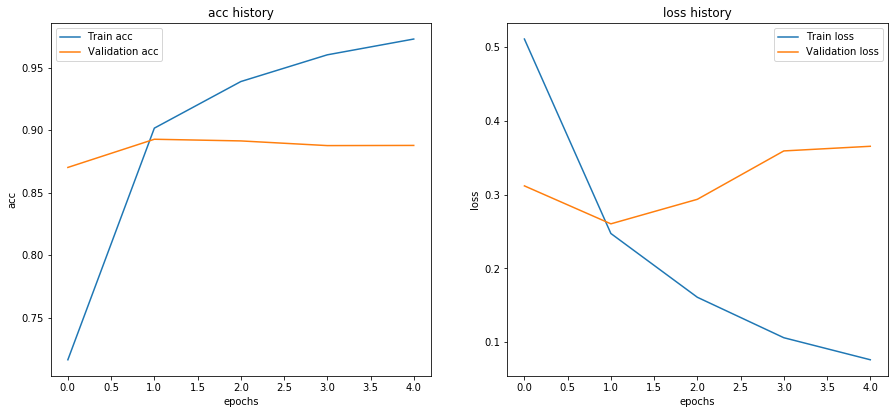

In [26]:
plot_keras_history(history, measures=['acc', 'loss'])